In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import xarray as xr
from glob import glob
import pandas as pd
import numpy as np
from pycurrents.num import mask_nonincreasing
from pycurrents.num import interp1
import matplotlib.ticker as mticker


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import MLD_ as m

import warnings
from math import floor, ceil

from scipy import linalg  # numpy linalg plus extras
import statsmodels.api as sm

from scipy import ndimage
from scipy import stats
from scipy import interpolate
from scipy import constants
import datetime as dt
import rioxarray as rxr
from sklearn.metrics import r2_score


Object `interpolate.interp1d` not found.


In [17]:
#Read in QC'd SOCCOM snapshot
SIZ_Floats_1=glob("XXX/*nc")

In [11]:
def PAR_extract(time_in, lat_in , lon_in):
    ''' function to get cdr_seaice_concentration from NASA Ocean color website daily mapped L3 files. 
    https://oceancolor.gsfc.nasa.gov/l3/
    units einstein m^-2 day^-1
    reference :
    Frouin, R., Ligner, D.W., and Gautier, C., 1989: A Simple analytical formula to compute clear sky total and photosynthetically available solar irradiance at the ocean surface. J. Geophys. Res., 94, 9731-9742.
     eg. A2016356.L3m_DAY_PAR.x_par.nc
    Uses Lat/Lon from yearly aggregate files
    for each time in float track ("time_in" = datetime data array, freq not specified so can work with temporally interpolated data)
    the closest SIC for that day is found. The mean is taken in case of two equidistance matches.
    
    returns array of cloud corrected par along float path
    
    '''

    
    #interpolate lat and lon
    lat_in=lat_in.interpolate_na(dim="JULD")
    lon_in=lon_in.interpolate_na(dim="JULD")
    
    PAR=np.zeros_like((time_in), dtype=float)
    
    for t in range(len(time_in)):
    #find day
        year=str(time_in[t].dt.year.values)
        if (time_in[t].dt.dayofyear) < 10:
            dayofyear="00"+str(time_in[t].dt.dayofyear.values)
            print(dayofyear)
        if (time_in[t].dt.dayofyear) <100 and (time_in[t].dt.dayofyear) >= 10: 
            dayofyear="0"+str(time_in[t].dt.dayofyear.values)
        if (time_in[t].dt.dayofyear) >= 100:
            dayofyear=str(time_in[t].dt.dayofyear.values)
        
        par_file= xr.open_dataset("/Users/shannonmcclish/Desktop/PAR_Daily/requested_files/A"+(year)+(dayofyear)+".L3m_DAY_PAR.x_par.nc")
        
        
        lon360=convert_180_lon_to_360(par_file.lon)
        par_file["lon360"]=xr.DataArray(data=lon360, dims=["lon"])
        lon_diff=abs(par_file.lon360-lon_in[t].values)
        lat_diff=abs(par_file.lat-lat_in[t].values)
        dist_weight = (lon_diff**2 + lat_diff**2)**0.5
        
        par_file=np.mean(par_file.where(dist_weight==dist_weight.min(), drop=True))
        
        
        PAR[t]=par_file.par.values

    return PAR

In [12]:
def calc_mld(ds, rdepth, sthreshold):
    mld_int = []
    for k in range(len(ds.JULD.values)):
        mld = m.calc_mld(ds.isel(JULD=k), ref_depth=rdepth, sigma_theta_crit=sthreshold)
        mld_int.append(mld)
    ds["MLD"]= xr.DataArray(mld_int, coords=ds.coords, dims=["JULD"])
    return ds

def open_SIZ_only(flt_, nlist):
    data=xr.open_dataset(flt_)
    for n in nlist: 
        if data["Float_ID"].values == "5903717":
            data=data.sel(JULD=slice("2016-01", "2019-01"))
        if data["Float_ID"].values == "5904180":
            data= data.sel(JULD=slice("2014-01","2019-03")) 
        if data["Float_ID"].values == "5904184":
            data= data.sel(JULD=slice("2014-01","2015-07")) 
        if data["Float_ID"].values == "5905375":
            data=data.sel(JULD=slice("2018-01", "2019-01"))
        if data["Float_ID"].values == "5905080":
            data=data.sel(JULD=slice("2017-09", "2020-05"))
    return data
    
def regrid(pvar, var, pgrid,coords,dims):
    "tranform data onto a standard grid using interp1 from pycurrents."
    nprofs = var.shape[0]
    newvar = np.ma.zeros((nprofs, pgrid.shape[0]))
    for i in range(nprofs):
        v = np.ma.masked_invalid(var[i])
        p = np.ma.masked_invalid(pvar[i])
        p = mask_nonincreasing(p[::-1])[::-1]
        newvar[i] = interp1(p, v, pgrid,axis=1)
    varn= xr.DataArray(newvar,coords=coords, dims=dims)
    #mask upper 5 m 
    varn=varn.where(varn.N_LEVELS>=5)
    return varn
    
def dsvars_togrid(ds_original):
    ''''when passed a SOCCOM float dataset (opened as xarray dataset) will return datset interpolated onto a uniform depth grid
    set by pgrid. Interpolation is only along the depth dimension using interp1 from pycurrents'''
    ds_grid=xr.Dataset()
    pgrid=np.arange(0,1500)
    coordinates=ds_original.coords
    ds_original=ds_original.interpolate_na(dim="JULD", method="linear", limit=2)
    ds_grid["OxygenSat"]=regrid(ds_original["Pressure"],ds_original["OxygenSat"],pgrid,coordinates,ds_original["OxygenSat"].dims)
    ds_grid["Temperature"]=regrid(ds_original["Pressure"],ds_original["Temperature"],pgrid,coordinates,ds_original["Temperature"].dims)
    ds_grid["Salinity"]=regrid(ds_original["Pressure"],ds_original["Salinity"],pgrid,coordinates,ds_original["Salinity"].dims)
    ds_grid["Depth"]=regrid(ds_original["Pressure"],ds_original["Depth"],pgrid,coordinates,ds_original["Depth"].dims)
    if "DIC_LIAR" in ds_original.variables.keys():
        ds_grid["DIC_LIAR"]=regrid(ds_original["Pressure"],ds_original["DIC_LIAR"],pgrid,coordinates,ds_original["DIC_LIAR"].dims)
    if "pCO2_LIAR" in ds_original.variables.keys():
        ds_grid["pCO2_LIAR"]=regrid(ds_original["Pressure"],ds_original["pCO2_LIAR"],pgrid,coordinates,ds_original["pCO2_LIAR"].dims)
    ds_grid["Oxygen"]=regrid(ds_original["Pressure"],ds_original["Oxygen"],pgrid,coordinates,ds_original["Oxygen"].dims)
    if "pH25C" in ds_original.variables.keys():
        ds_grid["pH25C"]=regrid(ds_original["Pressure"],ds_original["pH25C"],pgrid,coordinates,ds_original["pH25C"].dims)
    if "Nitrate" in ds_original.variables.keys():
        ds_grid["Nitrate"]=regrid(ds_original["Pressure"],ds_original["Nitrate"],pgrid,coordinates,ds_original["Nitrate"].dims)
    if "Chl_a_corr" in ds_original.variables.keys():
        ds_grid["Chl_a_corr"]=regrid(ds_original["Pressure"],ds_original["Chl_a_corr"],pgrid,coordinates,ds_original["Chl_a_corr"].dims)
    ds_grid['Sigma_theta']=regrid(ds_original["Pressure"],ds_original["Sigma_theta"],pgrid,coordinates,ds_original["Sigma_theta"].dims)
    if "b_bp700" in ds_original.variables.keys():
        ds_grid['b_bp700']=regrid(ds_original["Pressure"],ds_original["b_bp700"],pgrid,coordinates,ds_original["b_bp700"].dims)
    if "POC" in ds_original.variables.keys():
        ds_grid['POC']=regrid(ds_original["Pressure"],ds_original["POC"],pgrid,coordinates,ds_original["POC"].dims)
    ds_grid["Float_ID"]=ds_original["Float_ID"]
    ds_grid["Lat"]=ds_original["Lat"]
    ds_grid["Lat_QF"]=ds_original["Lat_QF"]
    ds_grid["Lon"]=ds_original["Lon"]
    ds_grid["MLD"]=ds_original["MLD"]
    ds_grid=ds_grid.rename({'N_LEVELS':'Pressure'})
    return ds_grid
 
    

    return da_match
def convert_360_lon_to_180(lons):
    """ Converts any-dimension array of longitudes from 0 to 360 to longitudes from -180 to 180.
    """
    lons = np.array(lons)
    outside_range = lons > 180
    lons[outside_range] = lons[outside_range] - 360
    return lons

def convert_180_lon_to_360(lons):
    """ Converts any-dimension array of longitudes from -180 to 180 t0 0 to 360 to longitude.
    """
    lons = np.array(lons)
    outside_range = lons < 0
    lons[outside_range] = lons[outside_range] + 360
    return lons

In [13]:
def bloom_metrics_daily (Chl_a, Cp):
    """find Growth initiation based on chl_a and Cp individually """
    #find Chl minimum before Chl maximum
    """Chl_a_min=Chl_a.min()"""
    Chl_a_maxt=Chl_a.where(Chl_a==Chl_a.max(), drop=True).JULD 
    #find timing of min in CHl occuring prior to apex
    Chl_a_beforemax=Chl_a.where(Chl_a.JULD< Chl_a_maxt.values, drop=True)
    Chl_a_mint=Chl_a_beforemax.where(Chl_a_beforemax==Chl_a_beforemax.min(), drop=True).JULD
    
    #find delta chl per day- center difference
    Chl_a_dt=Chl_a.diff(dim="JULD")
    time_center=Chl_a_dt.JULD.values - np.timedelta64(12, 'h')
    Chl_a_dt=Chl_a_dt.assign_coords({"JULD": time_center})
    #find where rate of change is positive
    Chl_a_dt=Chl_a_dt.where(Chl_a_dt>0, drop=True) 
    #median of positive period
    Chl_a_dt_median=Chl_a_dt.median() 
    #find where rate of change is positive and exceeds median d/dt threshold
    Chl_a_exceeds_median=Chl_a_dt.where(Chl_a_dt > Chl_a_dt_median, drop=True).JULD
    #find first occurence of threshold exceedance that follows min CHl/BBP (GI)
    GI_Chl_a=Chl_a_exceeds_median.where(Chl_a_exceeds_median.JULD > Chl_a_mint[0].values, drop=True)
    
    #choose first if repeat values
    if len(GI_Chl_a) > 1:
        GI_Chl_a=GI_Chl_a[0]
       
    #repeat with Cp
    Cp_min=Cp.min()
    Cp_maxt=Cp.where(Cp==Cp.max(), drop=True).JULD 
    Cp_beforemax=Cp.where(Cp.JULD< Cp_maxt.values, drop=True)
    Cp_mint=Cp_beforemax.where(Cp_beforemax==Cp_beforemax.min(), drop=True)[0].JULD
    Cp_dt=(Cp.diff(dim="JULD"))
    time_center=Cp_dt.JULD.values - np.timedelta64(12, 'h')
    Cp_dt=Cp_dt.assign_coords({"JULD": time_center})
    Cp_dt=Cp_dt.where(Cp_dt>0, drop=True) 
    
    Cp_dt_median=Cp_dt.median() 
    Cp_exceeds_median=Cp_dt.where(Cp_dt > Cp_dt_median, drop=True).JULD
    GI_Cp=Cp_exceeds_median.where(Cp_exceeds_median.JULD > Cp_mint.values, drop=True)
    
    Cp_GI=Cp.where(Cp.JULD>GI_Cp[0].values, drop=True) 
    if len(GI_Cp) > 1:
        GI_Cp=GI_Cp[0]
    
    return(GI_Chl_a, GI_Cp)


In [14]:
"""Find time before spring min/max where values become greater than two lowest
or highest winter value mean +/-'set_thresh_values' ex. Finds time when mean ML 
Nitrate decreases from winter mean +/- .2 umol/kg and continues decreasing to spring minimum"""
def thresholds2(ds,v, set_thresh_values, tstart,  max_=True):
    
    if max_ == True: 
        min_t=ds[v].where(ds[v]==ds[v].min(),drop=True)[0].JULD.values
        transition=ds[v].where(ds[v].JULD<min_t, drop=True)
        sorter=ds[v].sel(JULD=str(tstart)).where(ds[v].sel(JULD=str(tstart))<ds[v].sel(JULD=str(tstart)).max(), drop=True)
        maxtwo=sorter.max()
        twomean=(ds[v].sel(JULD=str(tstart)).max()+ maxtwo)/2
        """threshold exceedance is calculated from mean of 2 highest winter values"""
        set_threshold2=transition.where(transition>= (twomean-set_thresh_values), drop=True)
        

    else:
        max_t=ds[v].where(ds[v]==ds[v].max(),drop=True)[0].JULD.values
        min_t=ds[v].where(ds[v]==ds[v].min(),drop=True)[0].JULD.values
        #5905080 has highest O2 first day of July 2018 before ice cover-explicitly select spring O2 max-not neccessary step for other flt. timeseries
        if ds.Float_ID == "5905080" and tstart == 2018:
            print ("got here")
            max_t=ds[v].where(ds[v].where(ds[v].JULD>min_t, drop=True) == (ds[v].where(ds[v].JULD>min_t, drop=True)).max(), drop=True)[0].JULD.values
            print(max_t)
        transition=ds[v].where(ds[v].JULD<max_t, drop=True)
        sorter=ds[v].sel(JULD=str(tstart)).where(ds[v].sel(JULD=str(tstart))>ds[v].sel(JULD=str(tstart)).min(), drop=True)
        mintwo=sorter.min()
        twomean=(ds[v].sel(JULD=str(tstart)).min()+ mintwo)/2
        
        set_threshold2=transition.where(transition<=(twomean+set_thresh_values), drop=True)

    
    return set_threshold2



In [15]:
def Cphyto(bbp):
    """returns C-phyto [mg/m3] from float bbp (Johnson et al., 2017; Haëntjens
    et al., 2017; Graff et al 2015). 
    For each Cphyto profile subtract the mean estimated concentration between 900 m and 1500 m 
    from the entire vertical profile, in order to make sure that phytoplankton carbon asymptotes 
    towards zero at depth following Artega et al 2020 (who did 900-2000m, but I did 900-1500 because files
    only include to 1500m)"""
    #POC from BBP700
    POC=(bbp*3.12*10**4+3) #
    #C_phyto form POC 
    C_phyto = .19*POC
    background=C_phyto.sel(Pressure=slice(900,1500)).mean()
    C_phyto=C_phyto-background
    return C_phyto

In [16]:
def prof_data_2(ds, interp_na=False):
    """
    resamples to daily timestep with linerar interpolation where first and last day match date of 
    profile, timestep is set to zero
    """
    bin1=ds.groupby(ds.JULD.dt.floor(freq='1D')).mean()
    if interp_na==False:
        binnedint=bin1.resample(floor="D").interpolate()
    else:
        binnedint==bin1.resample(floor="D").interpolate_na()
    ds1=binnedint.rename_dims({"floor":"JULD"})
    ds1=binnedint.rename({'floor':'JULD'})
    #ds1["Float_ID"]=ds["Float_ID"]
    
    return ds1


Loop through flts, call functions to calculate GI, GI-cphyto, N/O2/S thresholds year by year. 
append each flt into a dataframe, concat dataframes for each year. convert back to xarray if plotting. 

In [18]:
def match_solar_radiation(lat_in, lon_in, time_in):
    """returns Mean surface downward short-wave radiation flux [Wm-2]
    This parameter is the amount of solar radiation (also known as shortwave radiation) that 
    reaches a horizontal plane at the surface of the Earth.
    This parameter is a mean over a particular time period (the processing period) which depends 
    on the data extracted. For the monthly averaged reanalysis and the monthly averaged ensemble members, 
    the processing period is the complete, whole month."""
    #time_in=time_in.values.astype(str)[0:10]
    #interpolate lat and lon
    lat_in=lat_in.interpolate_na(dim="JULD")
    lon_in=lon_in.interpolate_na(dim="JULD")
    lon_in=convert_360_lon_to_180(lon_in)
    
    rad=xr.open_dataset("/Users/shannonmcclish/Desktop/argo_data/Sea_Ice_Project/mean_solar_rad_down_monthly.nc")
    rad_noexpver=rad.sel(expver=1)
    MSD=np.zeros_like((time_in), dtype=float)
    for t in range(len(time_in)):
        
        lat_in_t=round(lat_in[t].values*4)/4
        lon_in_t=round(lon_in[t]*4)/4
        if np.isnan(lat_in_t)==True or np.isnan(lon_in_t)==True:
            MSD[t]="Nan"
        elif lat_in_t > -52.0:
            print(lat_in_t)
            MSD[t]="Nan"
        else:
            
            msd=rad_noexpver.msdwswrf.sel(latitude=lat_in_t, longitude=lon_in_t)
            msd=msd.interpolate_na(dim="time")
            msd=msd.resample(time="D").interpolate()
            time_in_t=time_in[t].values.astype(str)[0:10]

            MSD[t]=msd.sel(time=time_in_t)
    
    return MSD
def SIC_extract(time_in, lat_in , lon_in):
    ''' function to get cdr_seaice_concentration from NOAA/NSDIC daily files. Uses Lat/Lon from yearly aggregate files
    for each time in float track ("time_in" = datetime data array, freq not specified so can work with temporally interpolated data)
    the closest SIC for that day is found. The mean is taken in case of two equidistance matches.
    The sea ice conc is set to Nan where 2.53 (coast), 2.54 (land), 2.55 (missing data)
    
    returns array of sea ice conc along float path
    
    '''

  

    
    #interpolate lat and lon
    lat_in=lat_in.interpolate_na(dim="JULD")
    lon_in=lon_in.interpolate_na(dim="JULD")
    
    SIC=np.zeros_like((time_in), dtype=float)
    for t in range(len(time_in)):
    #find day
        if time_in[t].dt.year > 2008:
            year=str(time_in[t].dt.year.values)
        if ((time_in[t].dt.month)) < 10: 
            month="0"+str(time_in[t].dt.month.values)


        else: month=str(time_in[t].dt.month.values)



        if ((time_in[t].dt.day)) < 10: 
            day="0"+str(time_in[t].dt.day.values)


        else: day=str(time_in[t].dt.day.values)
        if time_in[t].dt.year < 2021:
            cdr_file = xr.open_dataset("/Users/shannonmcclish/Desktop/argo_data/Sea_Ice_Project/SeaIce/seaice_conc_daily_sh_"+year+month+day+'_f17_v04r00.nc')
            cdr_file_agg=xr.open_dataset("/Users/shannonmcclish/Desktop/argo_data/Sea_Ice_Project/Data/seaice_conc_daily_sh_"+year+'_v04r00.nc')
        else:
            cdr_file = xr.open_dataset("/Users/shannonmcclish/Desktop/argo_data/Sea_Ice_Project/nrt/daily/seaice_conc_daily_icdr_sh_"+year+month+day+'_f18_v02r00.nc')
            cdr_file_agg=xr.open_dataset("/Users/shannonmcclish/Desktop/argo_data/Sea_Ice_Project/nrt/agg/G02202-cdr-ancillary-sh.nc")

        cdr_file["latitude"]=cdr_file_agg.latitude
        cdr_file["longitude"]=cdr_file_agg.longitude
        lon360=convert_180_lon_to_360(cdr_file.longitude)
        cdr_file["lon360"]=xr.DataArray(data=lon360, dims=["y","x"])
        lon_diff=abs(cdr_file.lon360-lon_in[t].values)
        lat_diff=abs(cdr_file.latitude-lat_in[t].values)
        dist_weight = (lon_diff**2 + lat_diff**2)**0.5

        cdr_file=np.mean(cdr_file.where(dist_weight==dist_weight.min(), drop=True))


        #cdr_file=cdr_file.where(cdr_file.cdr_seaice_conc < 2.51)
        if cdr_file.cdr_seaice_conc.any() == 2.52:
            cdr_file.cdr_seaice_conc = NaN # lake mask
            print("lake")
        if cdr_file.cdr_seaice_conc.any() == 2.53:
            cdr_file.cdr_seaice_conc = NaN # coast mask
            print("coast")
        if cdr_file.cdr_seaice_conc.any() == 2.54:
            cdr_file.cdr_seaice_conc = NaN # land mask
            print("land")
        if cdr_file.cdr_seaice_conc.any() == 2.55:
            cdr_file.cdr_seaice_conc = NaN # land mask
            print("missing data")


        SIC[t]=cdr_file.cdr_seaice_conc.values

    return SIC

def mldmean(ds, Snorm=False):
    mldsliceN=np.ma.zeros((len(ds.JULD),1))
    mldsliceC=np.ma.zeros((len(ds.JULD),1))
    mldsliceO=np.ma.zeros((len(ds.JULD),1))
    mldsliceOSat=np.ma.zeros((len(ds.JULD),1))
    mldsliceS=np.ma.zeros((len(ds.JULD),1))
    mldsliceSig_theta=np.ma.zeros((len(ds.JULD),1))
    mldsliceT=np.ma.zeros((len(ds.JULD),1))
    mldsliceChl_a=np.ma.zeros((len(ds.JULD),1))
    mldslicebbp=np.ma.zeros((len(ds.JULD),1))
    mldsliceCp=np.ma.zeros((len(ds.JULD),1))
    mld_no_nan=ds.MLD.interpolate_na(dim="JULD", fill_value="extrapolate")
    if Snorm == True:
        mldsliceNSnorm=np.ma.zeros((len(ds.JULD),1))
       
    #mld_no_nan=ds.MLD.interpolate_na(dim="JULD", fill_value="extrapolate")
    for t in range(len(ds.JULD)):
        mldo=mld_no_nan.isel(JULD=t)
        
        mldsliceN[t]=ds.Nitrate[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        
        if Snorm == True:
            mldsliceNSnorm[t]=ds.Snorm_Nitrate[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
            
        if "DIC_LIAR" in ds.variables.keys():
            mldsliceC[t]=ds.DIC_LIAR[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceO[t]=ds.Oxygen[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceOSat[t]=ds.OxygenSat[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceS[t]=ds.Salinity[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceSig_theta[t]=ds.Sigma_theta[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceT[t]=ds.Temperature[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceChl_a[t]=ds.Chl_a_corr[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldslicebbp[t]=ds.b_bp700[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
        mldsliceCp[t]=ds.C_phyto[t,:].isel(Pressure=slice(0,ceil(mldo.values)+1)).mean(dim="Pressure")
    ds["ML_N"]= xr.DataArray(mldsliceN, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    if Snorm == True:
            ds["ML_NSnorm"]= xr.DataArray(mldsliceNSnorm, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
            
    ds["ML_C"]= xr.DataArray(mldsliceC, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_O"]= xr.DataArray(mldsliceO, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_OSat"]= xr.DataArray(mldsliceOSat, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_S"]= xr.DataArray(mldsliceS, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_Sig_theta"]= xr.DataArray(mldsliceSig_theta, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_T"]= xr.DataArray(mldsliceT, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_Chl_a"]= xr.DataArray(mldsliceChl_a, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_b_bp700"]= xr.DataArray(mldslicebbp, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    ds["ML_C_phyto"]= xr.DataArray(mldsliceCp, dims=["JULD", "ML"], coords=dict(JULD=(ds.JULD)))
    

    return ds

In [24]:

#NOTE must apply the QC to flt data (using May 2021 SOCCOM snapshot) prior to analysis
def phenology_DF_daily(region, t_start, t_end, t_slice, t_slice2):
    "t_start and t_end are time period start and end as intgers, tslice is time slice or year"
    DF = pd.DataFrame()
    for i in range(len(region)):
        ds1=xr.open_dataset(region[i])
        ds1=ds1.sel(JULD=t_slice)
        
        #6         
        if ds1.Float_ID in ["5904180", "5904397", "5904467", "5904468", "5904471", "5904472"] and t_start == 2015:
            print("2015 flt")
        #6
        elif ds1.Float_ID in ["5904180", "5904397", "5904467", "5904468", "5904471", "5904472"] and t_start == 2016:
            print("2016 flt")
        #11
        elif ds1.Float_ID in ["5904397", "5904467", "5904468", "5904471", "5904472", "5904859", "5905075", "5905077", "5905078", "5905100", "5905102"] and t_start == 2017:
            print("2017 flt")
        #14
        elif ds1.Float_ID in ["5904397","5904468", "5904471", "5904472", "5904855","5905075", "5905080", "5905100", "5905374", "5905636","5905635", "5905637","5905638", "5905639"] and t_start ==2018:
            print("2018 flt")
        #17
        elif ds1.Float_ID in ["5904855", "5905080", "5905636","5905635", "5905637","5905638", "5905991", "5905992", "5905994", "5905995", "5905997", "5906000", "5906005", "5906006", "5906033", "5906034"] and t_start== 2019:
            print("2019 flt")
        #11
        elif ds1.Float_ID in ["5905636", "5905637","5905991", "5905992", "5905994", "5905995", "5905997", "5905998","5906005","5906033", "5906034"] and t_start == 2020:
            print ("2020 flt")
        else:
            continue
        
       
        #calculate MLD
        ds_mld=calc_mld(ds1,10,.03)
        #Uniform pressure grid interpolation
        ds1=dsvars_togrid(ds_mld)
        
        ds1["C_phyto"]=Cphyto(ds1.b_bp700)
        ds1["Snorm_Nitrate"]=ds1.Nitrate*(ds1.Salinity/35) #see Papadimitriou et al 2012 or 2021 for details        
        #mixed layer means
        ds1=mldmean(ds1, Snorm=True)
        #find when float senes ice cover
        flt_SI=ds1.Lat_QF.where(ds1.Lat_QF==b'4',drop=True)
        #fill in missing upper ocean under ice values with ML mean values, only need to do this for varibles
        #that will be integrated down to 200m for analysis
        ds2=ds1.sel(Pressure=slice(0,45))
        ds2=ds2.assign_coords({"Pressure":ds2.Pressure})
        ds3=ds1.sel(Pressure=slice(45,201))
        ds3=ds3.assign_coords({"Pressure":ds3.Pressure+45})
        ds2["Snorm_Nitrate"]=ds2.Snorm_Nitrate.fillna(ds1.ML_NSnorm)
        ds2["Sigma_theta"]=ds2.Sigma_theta.fillna(ds1.ML_Sig_theta)
        ds2["Chl_a_corr"]=ds2.Chl_a_corr.fillna(ds1.ML_Chl_a)
        ds2["C_phyto"]=ds2.C_phyto.fillna(ds1.ML_C_phyto)
        ds_filled=xr.concat(([ds2, ds3]), dim="Pressure")
        ds_filled=ds_filled.where(ds_filled.Snorm_Nitrate.count(dim="Pressure")>=199, drop=True)
        
        if np.array(t_start) in ds1.JULD.dt.year.values and np.array(t_end) in ds1.JULD.dt.year.values: 
            with warnings.catch_warnings():
                # this will suppress all warnings in this block  
                warnings.simplefilter("ignore")
                ds1["SIC"]=xr.DataArray(data=SIC_extract(ds1.JULD, ds1.Lat, ds1.Lon), dims="JULD", coords={"JULD": ds1.JULD})
                ds1["RAD"]=xr.DataArray(data=match_solar_radiation(ds1.Lat, ds1.Lon, ds1.JULD), dims="JULD", coords={"JULD": ds1.JULD})   
        else: 
            print("Time period not captured by float")
            continue
        
        #double check SIC max>80% and nitrate is not missing more than 1 profiles
        if ds1.SIC.max().values <.8:
            print("SIC max < 80")
            continue
        if ds1.ML_N.dropna(dim="JULD").count() < (ds1.JULD.count()-1) or ds1.ML_C_phyto.dropna(dim="JULD").count() < (ds1.JULD.count()-1):
            print("missing N or Cphyto")
            continue
        if ds1.ML_O.dropna(dim="JULD").count() < (ds1.JULD.count()-1) or ds1.ML_S.dropna(dim="JULD").count() < (ds1.JULD.count()-1):
            print("missing O or S")
            continue
        if ds1.ML_Chl_a.dropna(dim="JULD").count() < (ds1.JULD.count()-1): 
            print("missing Chl")
            continue
        
        #daily resample-select July 1 to end of March
        float_ID=ds1.Float_ID
        ds1=ds1.drop(["Float_ID", "Lat_QF"])
        
        ds1=prof_data_2(ds1)
        ds1=ds1.sel(JULD=t_slice2)
        ds_filled=prof_data_2(ds_filled)
        ds_filled=ds_filled.sel(JULD=t_slice2)
        
        
        ########################
        mldmax= ds1.MLD.rolling(JULD=30, center=True).mean().max().values
        #integrate nitrate to winter MLD max
        N_MLD_unsmooth=ds_filled.Snorm_Nitrate.sel(Pressure=slice(5,mldmax+1))
        N_MLD_umolm3_unsmooth=N_MLD_unsmooth*(ds_filled.Sigma_theta.sel(Pressure=slice(5,mldmax+1))+1000)
        N_MLD_int_unsmooth=N_MLD_umolm3_unsmooth.sum(dim="Pressure")
        #smooth depth integrated nitrate, ML means (ds1) with 30 day running mean
        N_MLD_int_smooth=N_MLD_int_unsmooth.rolling(JULD=30, center=True, min_periods=1).mean()
        dNdt=N_MLD_int_smooth.diff(dim="JULD")
        ds1=ds1.rolling(JULD=30, center=True, min_periods=1).mean()
        ds1["Float_ID"]=float_ID
        
        
        #calculate Growth Initiation 
        GI,   GI_C =bloom_metrics_daily(ds1.ML_Chl_a.interpolate_na(dim="JULD"), ds1.ML_C_phyto.interpolate_na(dim="JULD"))
        #create output file
        
        #############
        output_ds=xr.Dataset(coords={"Float_ID":float_ID})
        output_ds["Float_ID"]=float_ID.values
        output_ds["Year"]=ds1.JULD[0].dt.year.values
        output_ds["SIC15_duration"]=len(ds1.SIC.where(ds1.SIC<.15,drop=True))
        output_ds["last_flt_detects_ice_prof"]=flt_SI.where(flt_SI==b'4',drop=True)[-1].JULD.dt.dayofyear.values            
        
        set_O_thresh_redfield=.2*(154/17) #Hedges et al 2002 
        flt_ratio=(ds1.ML_O.isel(JULD=slice(0,30)).mean()/ds1.ML_N.isel(JULD=slice(0,30)).mean()).values
        #set_O_thresh_flt=.2*flt_ratio
        mldmax_t=ds1.MLD.where(ds1.MLD==ds1.MLD.max().values, drop=True).JULD[-1]
        NS_exceeds_set_thresh=thresholds2(ds1, "ML_NSnorm",.2, t_start, max_=True)
        S_set_thresh15=thresholds2(ds1, "ML_S",.015,  t_start, max_=True)
        SIC2 =thresholds2(ds1, "SIC", .025,  t_start,max_=True)
        O_exceeds_set_thresh=thresholds2(ds1, "ML_O", set_O_thresh_redfield, t_start, max_=False)
        chl_exceeds_set_thresh=thresholds2(ds1, "ML_Chl_a", .035  ,t_start,max_=False) #.035 from .2 umol/kg nitrate and μg chl:μmol N from Moreau et al 2020
        
        SIC_last_max=ds1.SIC.where(ds1.SIC==ds1.SIC.max(), drop=True)[-1].JULD
        SIC_after_max=ds1.SIC.where(ds1.SIC.JULD>SIC_last_max.values, drop=True)
        SIC_min_after_max=SIC_after_max.where(SIC_after_max==ds1.SIC.min(), drop=True)[0].JULD
        SIC_min=ds1.SIC.where(ds1.SIC==ds1.SIC.min(), drop=True)[0].JULD
        SIC_before_min=ds1.SIC.where(ds1.SIC.JULD<SIC_min.values)
        
        
        N_min_date_smooth=N_MLD_int_smooth.sel(JULD=str(t_end)).where(N_MLD_int_smooth.sel(JULD=str(t_end))==N_MLD_int_smooth.sel(JULD=str(t_end)).min().values, drop=True)[0].JULD.values
        N_max_date_smooth=N_MLD_int_smooth.sel(JULD=str(t_start)).where(N_MLD_int_smooth.sel(JULD=str(t_start))==N_MLD_int_smooth.sel(JULD=str(t_start)).max().values, drop=True)[-1].JULD.values
        Nint_max_aftermldmax_smooth=N_MLD_int_smooth.sel(JULD=str(t_start)).where(N_MLD_int_smooth.sel(JULD=slice(mldmax_t.values, ds1.JULD[-1]))==N_MLD_int_smooth.sel(JULD=slice(mldmax_t.values, ds1.JULD[-1])).max().values, drop=True).JULD[-1]
        
        output_ds["SIC_max"]=ds1.SIC.max().values
        output_ds["MLCp_at_GI_C_mgm3"]=ds1.ML_C_phyto.interp(JULD=GI_C.values)[0].values
        output_ds["MLChla_at_GI_mgm3"]=ds1.ML_Chl_a.interp(JULD=GI.values)[0].values
        output_ds["MLCp_at_GI_mgm3"]=ds1.ML_C_phyto.interp(JULD=GI.values)[0].values
        output_ds["MLChla_at_GI_C_mgm3"]=ds1.ML_Chl_a.interp(JULD=GI_C.values)[0].values
        
        output_ds["ML_40"]=len(ds1.MLD.where(ds1.MLD<40, drop=True))
        output_ds["S_set_thresh15"]=S_set_thresh15[-1].JULD.dt.dayofyear.values
        if float_ID=="5905998":
            SIC_025=SIC_after_max.where(SIC_after_max<(ds1.SIC.max().values-.025), drop=True)[0].JULD
            output_ds["SIC_thresh"]=SIC_025.dt.dayofyear.values
        else:
            SIC_025=SIC2[-1].JULD
            output_ds["SIC_thresh"]=SIC_025.dt.dayofyear.values

        output_ds["Lat"]=ds1.Lat.mean().values
        Kd490_chl=(0.0166 + 0.0773* ds1.ML_Chl_a**0.6715) #Kd490 from Morel et al, 2007
        #Kd490 to KdPAR from (Morel et al., 2007 eq. 4a and 4b)
        KdPAR_chl=np.zeros(len(Kd490_chl))
        for i in range(len(ds1.JULD)):
            if Kd490_chl[i]**-1>ds1.MLD[i]:
                KdPAR_chl[i]=0.0864 + 0.884 * Kd490_chl[i] -0.00137*Kd490_chl[i]**-1
            else:
                KdPAR_chl[i]=0.0665 + 0.874 * Kd490_chl[i] - 0.00121*Kd490_chl[i]**-1
                 
        # RAD to PAR from Britton and Dodd 1976; 2.3*Irradiance [W/m2] = umol/m2/s *10**-6*86400 = [mol/m2/day]
        #similar to Gupta 2020 (assume ~40% RAD is PAR)
        ds1["ML_median_total"]=(((2.3*ds1.RAD)*10**-6)*86400)*np.exp(-KdPAR_chl*ds1.MLD/2)
        
        output_ds["GI_C"]=GI_C.dt.dayofyear.values
        output_ds["GI"]=GI.dt.dayofyear.values

        output_ds["bloom_duration_GI"]=ds1.ML_Chl_a.where(ds1.ML_Chl_a==ds1.ML_Chl_a.max(), drop=True).JULD-GI
        output_ds["bloom_duration_Chl_thresh"]=ds1.ML_Chl_a.where(ds1.ML_Chl_a==ds1.ML_Chl_a.max(), drop=True).JULD-chl_exceeds_set_thresh[-1].JULD

        output_ds["NO3_thresh"]=NS_exceeds_set_thresh[-1].JULD.dt.dayofyear.values
        output_ds["Chl_thresh"]=chl_exceeds_set_thresh[-1].JULD.dt.dayofyear.values
        if output_ds.Chl_thresh<200:
            output_ds["Chl_thresh"]=chl_exceeds_set_thresh[-1].JULD.dt.dayofyear.values+365
            
        output_ds["O2_thresh"]=O_exceeds_set_thresh[-1].JULD.dt.dayofyear.values
        
        if NS_exceeds_set_thresh[-1].JULD<mldmax_t.values:
            print(float_ID.values, "Nitrate threshold before MLD Maximum \n \n \n")
            output_ds["NCP"]=(dNdt.sel(JULD=slice(N_max_date_smooth,N_min_date_smooth))*(-106/16)*(10**-6)).sum().values
            output_ds["fractionNCP_atSIC0"]=((dNdt.sel(JULD=slice(N_max_date_smooth,N_min_date_smooth))*(-106/16)*(10**-6)).cumsum()/output_ds.NCP.values).where(ds1.JULD==SIC_min_after_max.values, drop=True)[0]
            ds1["median_light"]=ds1.ML_median_total*((1-ds1.SIC))+(ds1.SIC*ds1.ML_median_total*.09)
            output_ds["GP"]=N_max_date_smooth-N_min_date_smooth
            output_ds["Nint_max_date"]=N_max_date_smooth
            output_ds["GP_light"]=ds1.median_light.sel(JULD=slice(N_max_date_smooth, N_min_date_smooth)).sum()
        else:
            output_ds["NCP"]=(dNdt.sel(JULD=slice(Nint_max_aftermldmax_smooth,N_min_date_smooth))*(-106/16)*(10**-6)).sum().values
            ds1["median_light"]=ds1.ML_median_total*((1-ds1.SIC))+(ds1.SIC*ds1.ML_median_total*.09)
            if N_min_date_smooth<SIC_min_after_max.values:
                output_ds["fractionNCP_atSIC0"]=1
            else:
                output_ds["fractionNCP_atSIC0"]=((dNdt.sel(JULD=slice(Nint_max_aftermldmax_smooth,N_min_date_smooth))*(-106/16)*(10**-6)).cumsum()/output_ds.NCP.values).where(dNdt.JULD==SIC_min_after_max.values, drop=True)[0]
            output_ds["GP_light"]=ds1.median_light.sel(JULD=slice(Nint_max_aftermldmax_smooth, N_min_date_smooth)).sum()
            output_ds["GP"]=Nint_max_aftermldmax_smooth-N_min_date_smooth
            output_ds["Nint_max_date"]=Nint_max_aftermldmax_smooth
            
        output_ds["Nint_min_date"]=N_min_date_smooth
        output_ds["SIB_onset"]=(output_ds.O2_thresh+ output_ds.S_set_thresh15+ output_ds.SIC_thresh)/3
        output_ds["Lon"]=convert_180_lon_to_360(ds1.Lon.values.mean())

        MLD_maxt=ds1.MLD.where(ds1.MLD==ds1.MLD.max(), drop=True)[-1].JULD
        MLD_mint=ds1.MLD.where(ds1.MLD==ds1.MLD.min(), drop=True)[-1].JULD
        output_ds["MLD_maxt"]=MLD_maxt.dt.dayofyear.values
        output_ds["MLD_mint"]=MLD_mint.dt.dayofyear.values
        output_ds["MLD_max"]=ds1.MLD.max().values
        output_ds["MLD_min"]=ds1.MLD.min().values
        output_ds["median_light_sum"]=ds1.median_light.sum().values
        
        output_ds=output_ds.expand_dims("Float_ID")
        
        output_df=output_ds.to_dataframe()
        DF= DF.append(output_df)
        
        ##################writing out files for later plotting##############
        ds1["dNdt"]=dNdt
        write_out_ds=xr.Dataset(coords={"Float_ID":float_ID.astype(np.int64), "JULD":ds1.JULD})
        write_out_ds["Float_ID"]=float_ID.astype(np.int64) 
        write_out_ds["Nint_min_date"]=output_ds["Nint_min_date"]
        write_out_ds["NCP_daily"]=ds1.dNdt*(-106/16)*(10**-6)
        write_out_ds["Lat_bloomNCPpeak"]=ds1.Lat.interp(JULD=output_ds.Nint_min_date)
        write_out_ds["MLD_max"]=ds1.MLD.max()
        write_out_ds["Lon_bloomNCPpeak"]=ds1.Lon.interp(JULD=output_ds.Nint_min_date)
        write_out_ds["SIC15_duration"]=len(ds1.SIC.where(ds1.SIC<.15,drop=True))
        write_out_ds["SIC_min"]=SIC_min_after_max.values
        write_out_ds["ML_40"]=len(ds1.MLD.where(ds1.MLD<40, drop=True))
        write_out_ds["GI"]=GI
        write_out_ds["GI_Cp"]=GI_C
        write_out_ds["NO3_thresh"]=NS_exceeds_set_thresh[-1].JULD.values
        write_out_ds["O2_thresh"]=O_exceeds_set_thresh[-1].JULD.values
        write_out_ds["Salinity_thresh"]=S_set_thresh15[-1].JULD.values
        write_out_ds["SIC_thresh"]=SIC_025.values
        write_out_ds["NCP"]=output_ds["NCP"]
        write_out_ds["fractionNCP"]=output_ds["fractionNCP_atSIC0"]
        write_out_ds["GP"]=output_ds["GP"]
        write_out_ds["Nint_max_date"]=output_ds["Nint_max_date"]
        write_out_ds["SIC"]=ds1.SIC
        write_out_ds["median_light"]=ds1.median_light
        write_out_ds["median_light_sum"]=output_ds["median_light_sum"]
        write_out_ds["ML_Cp"]=ds1.ML_C_phyto
        write_out_ds["ML_Chl"]=ds1.ML_Chl_a
        write_out_ds["ML_N"]=ds1.ML_N
        write_out_ds["ML_S"]=ds1.ML_S
        write_out_ds["ML_O"]=ds1.ML_O
        #Need to write out files to net cdf for later grouping and plotting
        write_out_ds.to_netcdf("SPECIFY LOCATION HERE, encoding={"JULD":{'_FillValue': None}})

    return DF 

In [25]:
DF20_Timing=phenology_DF_daily(SIZ_Floats_1, 2020, 2021, slice("2020-06-15", "2021-05-15"), slice("2020-07", "2021-05"))

DF19_Timing=phenology_DF_daily(SIZ_Floats_1, 2019, 2020, slice("2019-06-15", "2020-05-15"), slice("2019-07", "2020-05"))

DF18_Timing=phenology_DF_daily(SIZ_Floats_1, 2018, 2019, slice("2018-06-15", "2019-05-15"), slice("2018-07", "2019-04"))

DF15_Timing=phenology_DF_daily(SIZ_Floats_1, 2015, 2016, slice("2015-06-15", "2016-05-15"), slice("2015-07", "2016-04"))

DF16_Timing=phenology_DF_daily(SIZ_Floats_1, 2016, 2017, slice("2016-06-15", "2017-05-15"), slice("2016-07", "2017-04"))

DF17_Timing=phenology_DF_daily(SIZ_Floats_1, 2017, 2018, slice("2017-06-15", "2018-05-15"), slice("2017-07", "2018-04"))

2020 flt
5905994


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5906005


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5905991


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5906034


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5905995


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5905992


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5905637


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5906033


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5906033 Nitrate threshold before MLD Maximum 
 
 

2020 flt
5905636


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5905997


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 flt
5905998


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905994


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905635


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5906005


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905991


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5906034


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5906000


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905995


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905992


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905637


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5906033


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905636


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905997


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5906006


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905080


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5904855


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2019 flt
5905638


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5904472


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905100


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905075


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905635


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5904468


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905637


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905636


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5904397


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905639


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5905374


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5905374 Nitrate threshold before MLD Maximum 
 
 

2018 flt
5905080


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


got here
2019-01-23T00:00:00.000000000
got here
2019-03-14T00:00:00.000000000
2018 flt
5904855


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5904855 Nitrate threshold before MLD Maximum 
 
 

2018 flt
5905638


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018 flt
5904471


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2015 flt
5904472


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2015 flt
5904467


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2015 flt
5904468


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2015 flt
5904180


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2015 flt
5904397


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2015 flt
5904471


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2016 flt
5904472


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2016 flt
5904467


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2016 flt
5904468


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2016 flt
5904180


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2016 flt
5904397


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2016 flt
5904471


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5904472


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5905100


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5905075


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5904467


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5904468


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5904468 Nitrate threshold before MLD Maximum 
 
 

2017 flt
5904859


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5905078


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5904397


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5905102


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5904471


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017 flt
5905077


/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/shannonmcclish/miniconda3/envs/SIZ/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
DF_Timing=pd.concat([DF15_Timing.reset_index(["JULD", "ML"], drop=True),DF16_Timing.reset_index(["JULD", "ML"], drop=True), DF17_Timing.reset_index(["JULD", "ML"], drop=True),DF18_Timing.reset_index(["JULD", "ML"], drop=True), DF19_Timing.reset_index(["JULD", "ML"], drop=True), DF20_Timing.reset_index(["JULD", "ML"], drop=True)])
DS_Timing=DF_Timing.to_xarray()



In [ ]:
#Read in analyzed datasets
All_flts_files=glob("/*nc")

In [30]:
All_flts_bySICday=pd.DataFrame()

for i in range(len(All_flts_files)):
    ds=xr.open_dataset(All_flts_files[i])
    ds["fltyear"]=str(ds.Float_ID.values)+str(ds.JULD[0].dt.year.values)
    ds["NCP_daily"]=ds.NCP_daily
    ds["SIB_onset"]=np.mean([ds.O2_thresh.dt.dayofyear.values, ds.Salinity_thresh.dt.dayofyear.values, ds.SIC_thresh.dt.dayofyear.values])
    days=ds.JULD.dt.floor("D")
    SIC_last=ds.SIC.where(ds.SIC==ds.SIC.min(),drop=True)[0].JULD.dt.floor("D")
    SIC_days=np.zeros(len(days))
    for d in range(len(days)):
        SIC_days[d]=(days[d]-SIC_last).dt.days.values
    SIC_days=xr.DataArray(data=SIC_days, dims=ds.JULD.dims, coords=ds.JULD.coords)
    ds=ds.assign_coords({"SIC_days":SIC_days})
    ds=ds.swap_dims({"JULD":"SIC_days"})
    if np.all(np.diff(ds.SIC_days.values)) == False:
        print(SIC_days.values)
    output_ds=xr.Dataset(coords={"fltyear":ds.fltyear, "SIC_days":ds.SIC_days})
    output_ds["Float_ID"]=ds.Float_ID.values
    output_ds["NCP_daily"]=ds.NCP_daily
    output_ds["SIC"]=ds.SIC
    output_ds["NCP"]=ds.NCP
    output_ds["SIB_onset"]=ds.SIB_onset
    output_ds["median_light"]=ds.median_light
    output_ds["median_light_cumsum"]=(ds.median_light).cumsum()
    
    output_ds["ML_Cp"]=ds.ML_Cp
    output_ds["ML_Chl"]=ds.ML_Chl
    
    
    output_ds=output_ds.expand_dims("fltyear")
    output_df=output_ds.to_dataframe()
    
    All_flts_bySICday=All_flts_bySICday.append(output_df)

def categorise(row):  
    if row['SIB_onset'] <= 290:
        return "Early SIB"
    elif row['SIB_onset'] >= 310:
        return "Late SIB"
    elif row['SIB_onset'] > 290  and row['SIB_onset'] < 310:
        return 'mid'

    
df_all_days_late=All_flts_bySICday.where(All_flts_bySICday.SIB_onset>=310)
df_all_days_early=All_flts_bySICday.where(All_flts_bySICday.SIB_onset<=290)


All_flts_bySICday['SIB_group'] = All_flts_bySICday.apply(lambda row: categorise(row), axis=1)

All_slicedb4_alldays=All_flts_bySICday.reset_index(["SIC_days"])
All_slicedb4_alldays=All_slicedb4_alldays[All_slicedb4_alldays["SIC_days"]<0]
All_slicedb4_alldays=All_slicedb4_alldays[All_slicedb4_alldays["SIC_days"]>-50]

All_slicedaft_alldays=All_flts_bySICday.reset_index(["SIC_days"])
All_slicedaft_alldays=All_slicedaft_alldays[All_slicedaft_alldays["SIC_days"]<50]
All_slicedaft_alldays=All_slicedaft_alldays[All_slicedaft_alldays["SIC_days"]>0]


All_sliced_alldays=All_flts_bySICday.reset_index(["SIC_days"])
All_sliced_alldays=All_sliced_alldays[All_sliced_alldays["SIC_days"]<50]
All_sliced_alldays=All_sliced_alldays[All_sliced_alldays["SIC_days"]>-50]


df_all_days_early_sliced=df_all_days_early.reset_index(["SIC_days"])
df_all_days_early_sliced=df_all_days_early_sliced[df_all_days_early_sliced["SIC_days"]<50]
df_all_days_early_sliced=df_all_days_early_sliced[df_all_days_early_sliced["SIC_days"]>-50]

df_all_days_late_sliced=df_all_days_late.reset_index(["SIC_days"])
df_all_days_late_sliced=df_all_days_late_sliced[df_all_days_late_sliced["SIC_days"]<50]
df_all_days_late_sliced=df_all_days_late_sliced[df_all_days_late_sliced["SIC_days"]>-50]

df_all_days_late_b4=df_all_days_late.reset_index(["SIC_days"])
df_all_days_late_b4=df_all_days_late_b4[df_all_days_late_b4["SIC_days"]<0]
df_all_days_late_b4=df_all_days_late_b4[df_all_days_late_b4["SIC_days"]>-50]
df_all_days_early_b4=df_all_days_early.reset_index(["SIC_days"])
df_all_days_early_b4=df_all_days_early_b4[df_all_days_early_b4["SIC_days"]<0]
df_all_days_early_b4=df_all_days_early_b4[df_all_days_early_b4["SIC_days"]>-50]
#after SIC min
df_all_days_early_aft=df_all_days_early.reset_index(["SIC_days"])
df_all_days_early_aft=df_all_days_early_aft[df_all_days_early_aft["SIC_days"]<50]
df_all_days_early_aft=df_all_days_early_aft[df_all_days_early_aft["SIC_days"]>0]
df_all_days_late_aft=df_all_days_late.reset_index(["SIC_days"])
df_all_days_late_aft=df_all_days_late_aft[df_all_days_late_aft["SIC_days"]<50]
df_all_days_late_aft=df_all_days_late_aft[df_all_days_late_aft["SIC_days"]>0]

#define bins
groups = pd.cut(df_all_days_early_sliced["SIC_days"], 10, right=True, include_lowest=True)

#display bin count by group variable
grouped_mean_early=df_all_days_early_sliced.groupby(groups).mean()
grouped_count_early=df_all_days_early_sliced.groupby(groups).count()

groups = pd.cut(df_all_days_late_sliced["SIC_days"], 10, right=True, include_lowest=True)

#display bin count by group variable
grouped_mean_late=df_all_days_late_sliced.groupby(groups).mean()
grouped_count_late=df_all_days_late_sliced.groupby(groups).count()


## FIGURE 1


In [412]:
#### CODE HERE

SO_raster=rxr.open_rasterio("/Users/shannonmcclish/Desktop/IBCSO_v2_bed_RGB.tif")
mpl.rcParams.update({'font.size': 18})
fig, axis = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.Stereographic(central_latitude=-90)), figsize=(12,15), dpi=300
)

SO_raster.plot.imshow(ax=axis)


for i in range(len(All_flts_files)):
    ds=xr.open_dataset(All_flts_files[i])
    ds["SIB_onset"]=np.mean([ds.O2_thresh.dt.dayofyear.values, ds.Salinity_thresh.dt.dayofyear.values, ds.SIC_thresh.dt.dayofyear.values])
    
    im=ds.plot.scatter(ax=axis,x="Lon_bloomNCPpeak", y="Lat_bloomNCPpeak", hue="NCP",cmap="magma", vmin=1, vmax=4, add_guide=False,
                           transform=ccrs.PlateCarree(),  s=80)



cbar=fig.colorbar(im ,orientation='vertical', shrink=.5)
cbar.set_label('bNCP [molC m$^{-2}$ bloom$^{-1}$]', rotation=270, labelpad=20)
axis.gridlines(color='.25', ylocs=np.arange(-90,50, 5), draw_labels=True)

#Limit the map to -50 degrees latitude and below.
axis.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())


axis.set_title("")

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

axis.set_boundary(circle, transform=axis.transAxes)

fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/Fig1_map.pdf")



## FIGURE 2

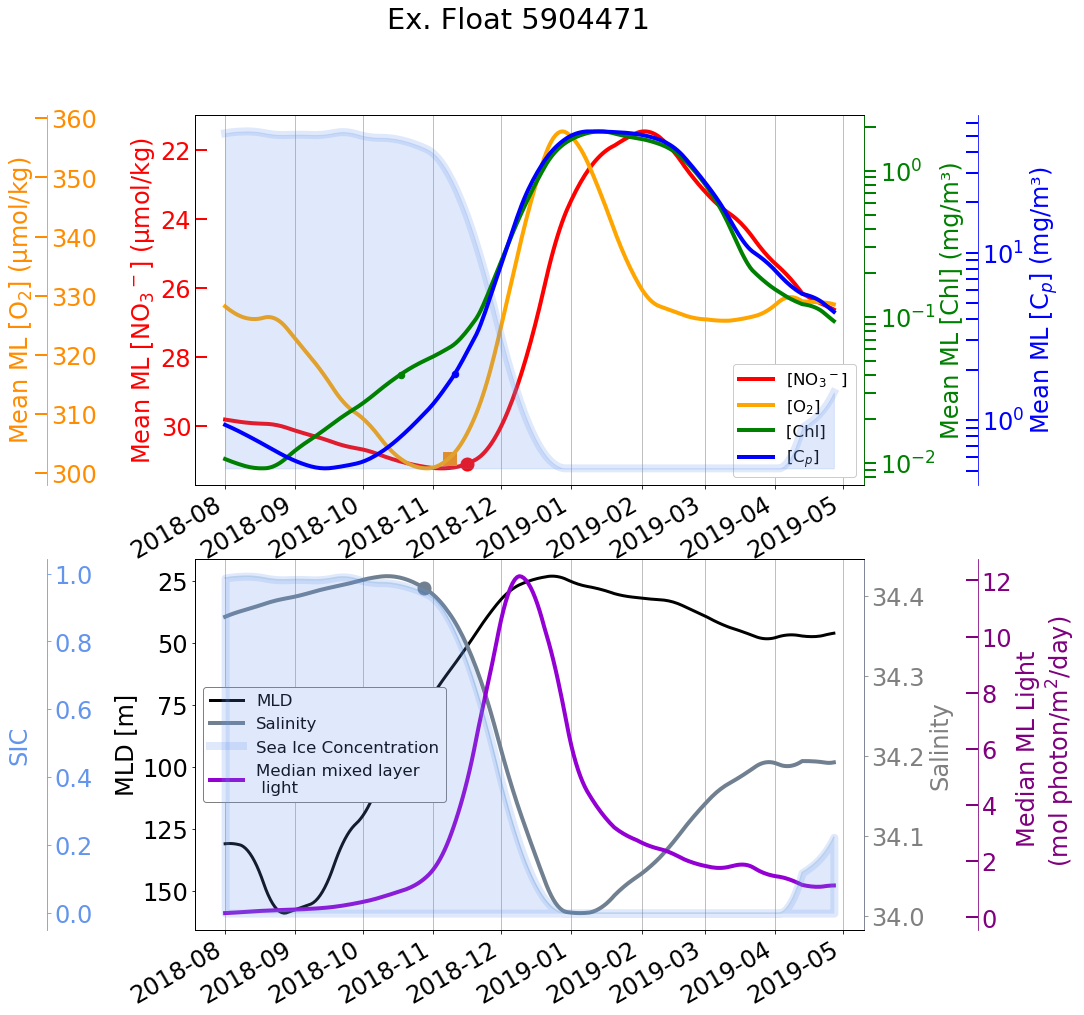

In [51]:
#ex float timeseries figure


fig, (ax1, ax6) = plt.subplots(2,1, figsize=(12,15),constrained_layout=False)#,gridspec_kw={'height_ratios': [6, 1, 6]})
for i in range(len(All_flts_files)):
    
    ds=xr.open_dataset(All_flts_files[i])
    if ds.Float_ID==5904471 and ds.JULD[0].dt.year==2018:
        ds=ds.sel(JULD=slice("2018-08", "2019-04"))
    #mpl.rcParams.update(mpl.rcParamsDefault)
        mpl.rcParams.update({'font.size': 24})
        #mpl.rcParams.update(mpl.rcParamsDefault)
        mpl.rcParams['lines.markersize'] = 13

        ds.ML_N.plot(ax=ax1,color="r", yincrease=False,linewidth=4, label="[NO$_3$$^-$] ")

        axO=ax1.twinx()
        axSICtop=ax1.twinx()
        axchl=ax1.twinx()
        axcp=ax1.twinx()
        axS=ax6.twinx()
        axRAD=ax6.twinx()
        axSICbot=ax6.twinx()
        
                             
        ds.ML_O.plot(ax=axO,color="orange",linewidth=4,label="[O"+"$_{2}$"+"]")
        ds.ML_Chl.plot(ax=axchl,color="g",linewidth=4,label="[Chl] ") #Σ
        #ds["r"]=netbiomassrate(ds.ML_Cp,Cp_MLD_int, ds.MLD)
        #ds.r.resample(JULD="14D").mean().plot(ax=ax45, color="cyan")
        ds.ML_Cp.plot(ax=axcp,color="b",linewidth=4, label="[C$_p$]")
        ds.SIC.plot(ax=axSICtop, label="Sea Ice Concentration",alpha=0.2, linewidth=8, color="cornflowerblue")
        axSICtop.fill_between(ds.JULD.values,ds.SIC.values, alpha=0.2, color="cornflowerblue")
        ds.ML_S.plot(ax=axS, linewidth=4, color="slategrey",label="Salinity")
        ds.SIC.plot(ax=axSICbot,alpha=0.2, label="Sea Ice Concentration")
        axSICbot.fill_between(ds.JULD.values,ds.SIC.values, alpha=0.2,linewidth=8, color="cornflowerblue")
        #(ds.RAD/ds.MLD*(1-ds.SIC)+(ds.RAD/ds.MLD*(.10*ds.SIC))).plot(ax=axRAD, color="darkviolet",linewidth=4, label="Mean ML radiation [W/m³]")
        ds.median_PAR.plot(ax=axRAD, color="darkviolet",linewidth=4, label="Median mixed layer \n light")
        #Assuming 10% transmittance through sea ice see https://www.frontiersin.org/articles/10.3389/fmars.2020.00536/full#T5
        # for details
        
        ax1.scatter(x=ds.NO3_thresh.values, y=ds.ML_N.sel(JULD=ds.NO3_thresh.values).values,  color="r",label="[NO"+"$_{3}$"+"-] decrease")
        axO.scatter(x=ds.O2_thresh.values, y=ds.ML_O.sel(JULD=ds.O2_thresh.values).values ,color="darkorange", marker="s",label="[O"+"$_{2}$"+"] increase")
        axcp.scatter(x=ds.GI_Cp.values, y=ds.ML_Cp.interp(JULD=ds.GI_Cp.values).values, marker=".",color="blue", label="GI_Cp")
        axchl.scatter(x=ds.GI.values, y=ds.ML_Chl.interp(JULD=ds.GI.values).values, marker=".",color="green", label="GI_int")
        axS.scatter(x=ds.Salinity_thresh.values, y=ds.ML_S.sel(JULD=ds.Salinity_thresh.values).values, color="slategrey", label="Salinity decrease")
        ds.MLD.plot(ax=ax6,color="black",yincrease=False, label="MLD", linewidth=3)
        
        
        ax1.set_xlabel("")
        
        
        axSICtop.get_xaxis().set_visible(False)
        axO.get_xaxis().set_visible(False)
        axchl.get_xaxis().set_visible(False)
        axcp.get_xaxis().set_visible(False)
        
        axcp.set_yscale("log")
        axchl.set_yscale("log")
        axcp.spines["right"].set_position(("axes", 1.17))

        axO.spines["right"].set_position(("axes", -.22))
        
        axS.spines["right"].set_color('grey')
        axRAD.spines["right"].set_position(("axes", 1.17))

        axSICbot.spines["right"].set_position(("axes", -.22))

        axcp.yaxis.set_tick_params(which='both', size=12, width=2, direction='in')
        axchl.yaxis.set_tick_params(which='both', size=12, width=2, direction='out')
        
        ax1.yaxis.set_tick_params(which='major', size=12, width=2, direction='in')
        axO.yaxis.set_tick_params(which='major', size=12, width=2, direction='in')
        axRAD.yaxis.set_tick_params(which='major', size=12, width=2, direction='in')

        axSICbot.yaxis.set_label_coords(-.28, .5)
        axO.yaxis.set_label_coords(-.28, .5)

        axO.spines["right"].set_color("darkorange")
        axcp.spines["right"].set_color('blue')
        ax6.spines["right"].set_color("cornflowerblue")
        axchl.spines["right"].set_color("green")
        ax1.spines["left"].set_color("red")
        axRAD.spines["right"].set_color("purple")
        axSICbot.spines["right"].set_color("cornflowerblue")


        ax1.tick_params(axis='y', colors='red')
        axO.tick_params(axis='y', colors='darkorange')
        axchl.tick_params(axis='y', colors='green', which='both')
        axRAD.tick_params(axis='y', colors='purple')
        #axcp.tick_params(axis='y', colors='blue')
        axcp.tick_params(axis='y', colors='blue', which='both')
        axSICbot.tick_params(axis='y', colors='cornflowerblue')
        axS.tick_params(axis='y', colors='grey')

        ax1.set_ylabel("Mean ML [NO"+"$_{3}$"+"$^-$] (µmol/kg)")
        axO.set_ylabel("Mean ML [O"+"$_{2}$"+"] (µmol/kg)")
        axcp.set_ylabel("Mean ML [C$_p$] (mg/m³)")
        axchl.set_ylabel("Mean ML [Chl] (mg/m³)")
        ax6.set_ylabel("MLD [m]")
        axSICbot.set_ylabel("SIC")
        axRAD.set_ylabel("Median ML Light \n (mol photon/m"+"$^{2}$"+"/day)")
        axS.set_ylabel("Salinity")
        
        ax1.yaxis.label.set_color('red')
        axchl.yaxis.label.set_color('green')
        axO.yaxis.label.set_color('darkorange')
        axcp.yaxis.label.set_color('blue')
        axSICbot.yaxis.label.set_color("cornflowerblue")
        axRAD.yaxis.label.set_color('purple')
        
        axS.yaxis.label.set_color('grey')

        ax6.xaxis.grid()
        ax1.xaxis.grid()

        
        axSICtop.set_axis_off()
        
        #axSICbot.set_axis_off()

        Oh, Ol=axO.get_legend_handles_labels()
        Nh, Nl=ax1.get_legend_handles_labels()
        Ch, Cl=axchl.get_legend_handles_labels()
        Cph, Cpl=axcp.get_legend_handles_labels()
        Sh, Sl=axS.get_legend_handles_labels()
        SICh, SICl=axSICtop.get_legend_handles_labels()
        MLDh, MLDl=ax6.get_legend_handles_labels()
        RADh, RADl=axRAD.get_legend_handles_labels()
       
        lg1=ax6.legend([ MLDh[0],  Sh[0] , SICh[0], RADh[0]],[ MLDl[0], Sl[0],SICl[0], RADl[0]], loc="center left", fontsize="x-small",framealpha=1)
        lg2=ax1.legend([Nh[0], Oh[0], Ch[0], Cph[0]],[Nl[0], Ol[0],  Cl[0],Cpl[0]], loc="lower right",fontsize="x-small",framealpha=1)
        frame1 = lg1.get_frame()
        frame1.set_facecolor('white')
        frame1.set_edgecolor('grey')

        ax6.set_xlabel("")
        ax6.set_title("")
        axS.set_title("")
        axRAD.set_title("")
        axSICbot.set_title("")
        ax1.set_title("")
        axO.set_title("")
        axchl.set_title("")
        axSICtop.set_title("")
        axcp.set_title("")
        
        title=fig.suptitle("Ex. Float "+str(ds.Float_ID.values))
        plt.show()
        fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/ExfltFigSSIZ"+str(ds.Float_ID.values)+".pdf", bbox_extra_artists=(), dpi=300,bbox_inches='tight')


## FIGURE 3

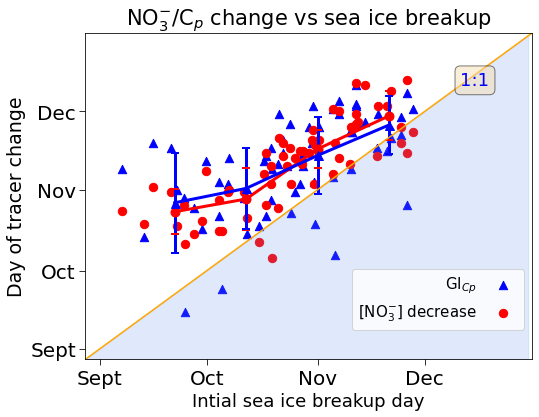

In [49]:
fig, ax=plt.subplots(figsize=(8,6))
#plt.rcParams.update({'font.size': 22})
mpl.rcParams.update({'font.size': 18})
        
mpl.rcParams['lines.markersize'] = 9
f=ax.scatter(x=DS_Timing.SIB_onset, y=DS_Timing.GI_C, color="b", label="GI$_{Cp}$", marker="^", s=70)

f=ax.scatter(x=DS_Timing.SIB_onset, y=DS_Timing.NO3_thresh, color="red", label="[NO$_{3}^{-}$] decrease", s=70)

bin260=DS_Timing.where(DS_Timing.SIB_onset>=255, drop=True)
bin280=DS_Timing.where(DS_Timing.SIB_onset>=275, drop=True)
bin300=DS_Timing.where(DS_Timing.SIB_onset>=295, drop=True)
bin320=DS_Timing.where(DS_Timing.SIB_onset>=315, drop=True)

bin260=bin260.where(bin260.SIB_onset<275, drop=True)
bin280=bin280.where(bin280.SIB_onset<295, drop=True)
bin300=bin300.where(bin300.SIB_onset<315, drop=True)

Xval=np.array([265, 285, 305, 325])
Nmean=np.array([bin260.NO3_thresh.mean().values, bin280.NO3_thresh.mean().values, bin300.NO3_thresh.mean().values, bin320.NO3_thresh.mean().values])
Cmean=np.array([bin260.GI_C.mean().values, bin280.GI_C.mean().values, bin300.GI_C.mean().values, bin320.GI_C.mean().values])
        

Nstd=np.array([bin260.NO3_thresh.std().values, bin280.NO3_thresh.std().values, bin300.NO3_thresh.std().values, bin320.NO3_thresh.std().values])
Cstd=np.array([bin260.GI_C.std().values, bin280.GI_C.std().values, bin300.GI_C.std().values, bin320.GI_C.std().values])


ax.errorbar(Xval, Nmean, Nstd, linestyle='solid', linewidth=3, color="r", marker="o",fmt='_', capthick=2, capsize=4)
ax.errorbar(Xval, Cmean, Cstd, linestyle='solid', linewidth=3, color="b", marker="^",fmt='_', capthick=2, capsize=4)


ax.set_xlabel("Intial sea ice breakup day")
ax.set_ylabel("Day of tracer change",fontsize=19)
ax.set_xlim(240, 365)
ax.set_ylim(240, 365)
line=ax.plot([240,365], [240,365], color="orange")

ax.fill_between( np.arange(240, 365), y1=240, y2=np.arange(240, 365) , alpha=0.2, color="cornflowerblue")
ax.set_xticks([244, 274, 305, 335])
ax.set_xticklabels(['Sept', 'Oct', 'Nov', "Dec"])
ax.set_yticks([244, 274, 305, 335])
ax.set_yticklabels(['Sept', 'Oct', 'Nov', "Dec"])
#ax.xaxis.set_minor_locator(MultipleLocator(15))
ax.tick_params(which='major', length=6)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# Define bbox style
box_style=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Text inside a box
plt.text(345,345, "1:1",{'color':'blue','size':18},bbox=box_style)

ax.set_title("NO$_{3}^{-}$/C$_p$ change vs sea ice breakup",fontsize=21) #"$O_{2}$"
#ax.set_title(str((DS_daily.Cp_at_GI_C_mgm3/DS_daily.Chla_at_GI_Cmgm3).mean().values)[0:4]+"mean C:CHl at GI_C")
ax.legend(fontsize="small", loc='best', bbox_to_anchor=(.5, 0., .5, .3), markerfirst=False)
fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Timing_all_wrtSIB_vf.pdf", dpi=300, bbox_inches='tight')


## FIGURE 4

0.023495750046713948
0.012783053686808342


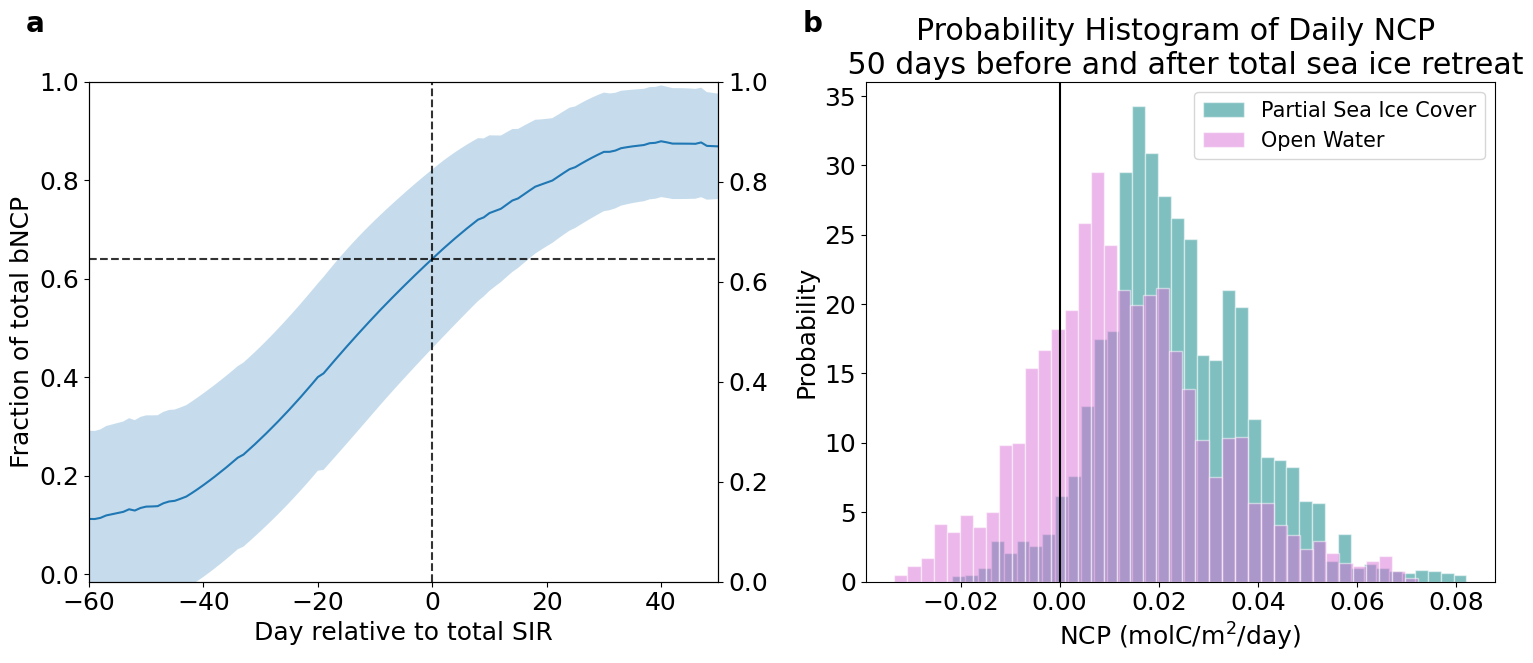

In [48]:
fig, (ax, ax2) = plt.subplots(1,2 , figsize=(16, 7), dpi=100)
ax1=ax.twinx()
mpl.rcParams.update({'font.size': 18, 'font.family':"sans-serif"})
x=ds_all_flts.SIC_days
y1=(ds_all_flts.FracNCP_mean)+ds_all_flts.FracNCP_std
y2=(ds_all_flts).FracNCP_mean-ds_all_flts.FracNCP_std
ds_all_flts.FracNCP_mean.plot(ax=ax)
ax.fill_between(x,y1, y2, alpha=.25)
ax.set_xlabel("Day relative to total SIR")
ax.set_ylabel("Fraction of total bNCP")
ax.set_xlim(-60, 50)
ax.set_ylim(-.015, 1)
ax.axvline(x=0, linestyle="dashed", color="black", alpha=.8)
ax.axhline(y=ds_all_flts.FracNCP_mean.sel(SIC_days=0).values, linestyle="dashed", color="black", alpha=.8)

x1 = All_slicedb4_alldays['NCP_daily']
print(All_slicedb4_alldays["NCP_daily"].mean())
x2 = All_slicedaft_alldays['NCP_daily']
print(All_slicedaft_alldays['NCP_daily'].mean())
# Normalize
kwargs = dict(alpha=0.5, bins=40, density=True, stacked=True)
#plt.figure(figsize=(10,7), dpi= 80)
# Plot
ax2.hist(x1, **kwargs, color='teal', label='Partial Sea Ice Cover', linewidth=1, edgecolor="white")
ax2.hist(x2, **kwargs, color='orchid', label='Open Water', linewidth=1, edgecolor="white")

ax2.set_title('Probability Histogram of Daily NCP \n 50 days before and after total sea ice retreat')
ax2.set_ylabel('Probability')
ax2.set_xlabel("NCP (molC/m$^2$/day)")
ax2.legend(prop={'size': 15})
ax2.axvline(x=0, color="black")
ax.text(-0.1, 1.1, "a", transform=ax.transAxes, 
            size=20, weight='bold')
ax2.text(-0.1, 1.1, "b", transform=ax2.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Fig4FracNCPandhist.pdf", dpi=300)


## FIGURE 5

0.2745141926657104


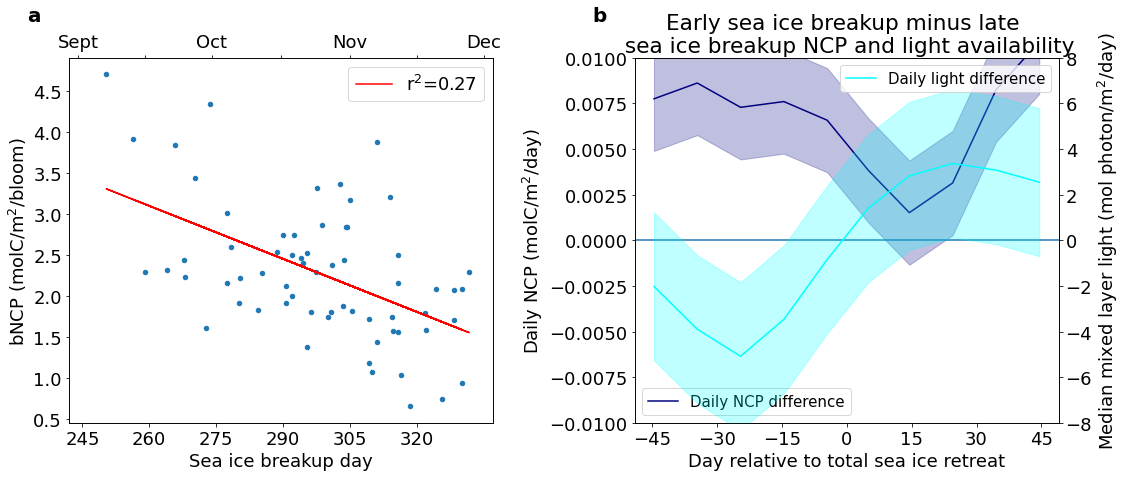

In [43]:
import statsmodels.api as sma

from sklearn.linear_model import LinearRegression

model = LinearRegression()
mpl.rcParams.update({'font.size': 18})
fig, (ax, ax2)= plt.subplots(1,2,figsize=(16,7))
reg = LinearRegression().fit(DF_Timing.SIB_onset.values.reshape(-1, 1), DF_Timing.NCP.values)
print(reg.score(DF_Timing.SIB_onset.values.reshape(-1, 1), DF_Timing.NCP.values))

ax1=ax.twiny()
ax.set_xticks([245, 260, 275, 290, 305, 320])
ax1.set_xticks([244, 259, 274, 289.5, 305, 320, 335])
ax1.set_xticklabels(['Sept',"", 'Oct', "",'Nov', "","Dec"])

DF_Timing.plot.scatter(ax=ax, x="SIB_onset", y="NCP")
z = np.polyfit(DF_Timing.SIB_onset.values, DF_Timing.NCP.values, 1)
p = np.poly1d(z)
ax.plot(DF_Timing.SIB_onset.values, p(DF_Timing.SIB_onset.values),"r", label="r$^2$="+str(np.round(reg.score(DF_Timing.SIB_onset.values.reshape(-1, 1), DF_Timing.NCP.values),3))[0:4])
ax.legend()
ax.set_ylabel("bNCP (molC/m$^2$/bloom)")
ax.set_xlabel("Sea ice breakup day")
ax1.set_xlabel("")
ax.set_xlim(242, 337)
ax1.set_xlim(242, 337)

x=grouped_mean_early.SIC_days
y1=(grouped_mean_early.NCP_daily-grouped_mean_late.NCP_daily)+(grouped_mean_early.NCP_daily-grouped_mean_late.NCP_daily).std()
y2=(grouped_mean_early.NCP_daily-grouped_mean_late.NCP_daily)-(grouped_mean_early.NCP_daily-grouped_mean_late.NCP_daily).std()
y1a=(grouped_mean_early.median_light-grouped_mean_late.median_light)-(grouped_mean_early.median_light-grouped_mean_late.median_light).std()
y2a=(grouped_mean_early.median_light-grouped_mean_late.median_light)+(grouped_mean_early.median_light-grouped_mean_late.median_light).std()
ax3=ax2.twinx()
line1=(grouped_mean_early.NCP_daily-grouped_mean_late.NCP_daily)#.plot(ax=ax, label="Daily NCP difference", color="navy")
ax2.plot(x, line1, color="navy", label="Daily NCP difference")
ax2.fill_between(x, y1, y2, alpha=.25, color="navy")
line2=(grouped_mean_early.median_light-grouped_mean_late.median_light)#.plot(ax=ax1, label="Daily light difference", color="cyan")
ax3.plot(x, line2,label="Daily light difference", color="cyan")
ax3.fill_between(x, y1a, y2a, alpha=.25, color="cyan")

ax2.set_xlabel("Day relative to total sea ice retreat")
ax2.set_ylabel("Daily NCP")
ax2.set_xticks([-45, -30, -15,0,15,30,45])
ax3.set_xticks([-45, -30, -15,0,15,30,45])

ax3.set_ylim(-8,8)
ax2.set_ylim(-.01,.01)
ax2.set_title("Early sea ice breakup minus late \n sea ice breakup NCP and light availability")
ax3.set_ylabel("Median mixed layer light (mol photon/m"+"$^{2}$"+"/day)")
ax2.set_ylabel("Daily NCP (molC/m$^2$/day)")
ax2.axhline()
ax2.legend(prop={'size': 15}, loc="lower left")
ax3.legend(prop={'size': 15})

ax.text(-0.1, 1.1, "a", transform=ax.transAxes, 
            size=20, weight='bold')
ax2.text(-0.1, 1.1, "b", transform=ax2.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Fig5SIB_NCP", dpi=300)


## Supplemental Fig 1 a, b

1.5950116833798604 mean no outlier


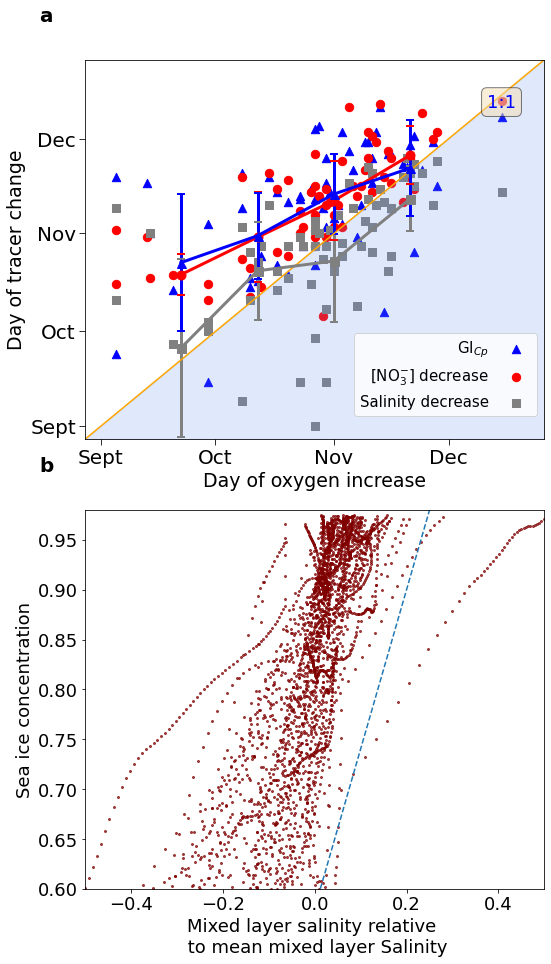

In [242]:
fig, (ax, ax1) =plt.subplots(2,1, figsize=(8, 13))
#plt.rcParams.update({'font.size': 22})
mpl.rcParams.update({'font.size': 18})
        
mpl.rcParams['lines.markersize'] = 9
f=ax.scatter(x=DS_Timing.O2_thresh, y=DS_Timing.GI_C, color="b", label="GI$_{Cp}$", marker="^", s=70)

f=ax.scatter(x=DS_Timing.O2_thresh, y=DS_Timing.NO3_thresh, color="red", label="[NO$_{3}^{-}$] decrease", s=70)
f=ax.scatter(x=DS_Timing.O2_thresh, y=DS_Timing.S_set_thresh15, color="grey", marker="s", label="Salinity decrease", s=70)

bin250=DS_Timing.where(DS_Timing.O2_thresh>=255, drop=True)
bin270=DS_Timing.where(DS_Timing.O2_thresh>=275, drop=True)
bin290=DS_Timing.where(DS_Timing.O2_thresh>=295, drop=True)
bin310=DS_Timing.where(DS_Timing.O2_thresh>=315, drop=True)

bin250=bin250.where(bin250.O2_thresh<275, drop=True)
bin270=bin270.where(bin270.O2_thresh<295, drop=True)
bin290=bin290.where(bin290.O2_thresh<315, drop=True)

Xval=np.array([265, 285, 305, 325])
Nmean=np.array([bin250.NO3_thresh.mean().values, bin270.NO3_thresh.mean().values, bin290.NO3_thresh.mean().values, bin310.NO3_thresh.mean().values])
Smean=np.array([bin250.S_set_thresh15.mean().values, bin270.S_set_thresh15.mean().values, bin290.S_set_thresh15.mean().values, bin310.S_set_thresh15.mean().values])
Cmean=np.array([ bin250.GI_C.mean().values, bin270.GI_C.mean().values, bin290.GI_C.mean().values, bin310.GI_C.mean().values])


Nstd=np.array([ bin250.NO3_thresh.std().values, bin270.NO3_thresh.std().values, bin290.NO3_thresh.std().values, bin310.NO3_thresh.std().values])
Sstd=np.array([ bin250.S_set_thresh15.std().values, bin270.S_set_thresh15.std().values, bin290.S_set_thresh15.std().values, bin310.S_set_thresh15.std().values])
Cstd=np.array([ bin250.GI_C.std().values, bin270.GI_C.std().values, bin290.GI_C.std().values, bin310.GI_C.std().values])


ax.errorbar(Xval, Nmean, Nstd, linestyle='solid', linewidth=3, color="r", marker="o",fmt='_', capthick=2, capsize=4)
ax.errorbar(Xval, Smean, Sstd, linestyle='solid', linewidth=3, color="grey", marker="s",fmt='_', capthick=2, capsize=4)
ax.errorbar(Xval, Cmean, Cstd, linestyle='solid', linewidth=3, color="b", marker="^",fmt='_', capthick=2, capsize=4)

ax.set_xlabel("Day of oxygen increase",fontsize=19)

ax.set_ylabel("Day of tracer change",fontsize=19)
ax.set_xlim(240, 360)
ax.set_ylim(240, 360)
line=ax.plot([240,365], [240,365], color="orange")

ax.fill_between( np.arange(240, 365), y1=240, y2=np.arange(240, 365) , alpha=0.2, color="cornflowerblue")
ax.set_xticks([244, 274, 305, 335])
ax.set_xticklabels(['Sept', 'Oct', 'Nov', "Dec"])
ax.set_yticks([244, 274, 305, 335])
ax.set_yticklabels(['Sept', 'Oct', 'Nov', "Dec"])
#ax.xaxis.set_minor_locator(MultipleLocator(15))
ax.tick_params(which='major', length=6)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# Define bbox style
box_style=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Text inside a box
ax.text(345,345, "1:1",{'color':'blue','size':18},bbox=box_style)

#ax.set_title("NO$_{3}^{-}$/C-phyto change vs Sea Ice breakup",fontsize=21) #"$O_{2}$"
#ax.set_title(str((DS_daily.Cp_at_GI_C_mgm3/DS_daily.Chla_at_GI_Cmgm3).mean().values)[0:4]+"mean C:CHl at GI_C")
ax.legend(fontsize="small", loc='best', bbox_to_anchor=(.5, 0., .5, .3), markerfirst=False)

slope_=np.zeros((1))

for flt in range(len(All_flts_files)):
    ds1=xr.open_dataset(All_flts_files[flt])
    SIC_lower=ds1.where(ds1.JULD> ds1.SIC_thresh.values, drop=True).where(ds1.SIC>.6, drop=True)
    SIC_lower["norm_S"]=SIC_lower.ML_S-SIC_lower.ML_S.mean()
    slope_flt, b_flt = np.polyfit(SIC_lower.ML_S.values.reshape(-1), SIC_lower.SIC.values.flatten(), 1)
    SIC_lower.plot.scatter(ax=ax1, x="norm_S", y="SIC", color="maroon", alpha=.7, s=4)
    slope_=np.append(slope_, slope_flt)
    
ax1.set_xlabel("Mixed layer salinity relative \n to mean mixed layer Salinity")
ax1.set_ylabel("Sea ice concentration")

slope_=slope_[1:]
q25, q75 = np.percentile(slope_, 25), np.percentile(slope_, 75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in slope_ if x < lower or x > upper]
# remove outliers
outliers_removed = [x for x in slope_ if x > lower and x < upper]
print(np.mean(outliers_removed), "mean no outlier")
# add arbitrary line with mean slope (no outliers) 
x_vals = np.array(ax1.get_xlim())
y_vals = ax1.get_ylim()[0] + np.mean(outliers_removed) * x_vals
ax1.plot(x_vals, y_vals, '--', label= "slope= 1.6")
ax1.set_xlim(-.5, .5)
ax1.set_ylim(.6, .98)

fig.tight_layout()
ax.text(-0.1, 1.1, "a", transform=ax.transAxes, 
            size=20, weight='bold')
ax1.text(-0.1, 1.1, "b", transform=ax1.transAxes, 
            size=20, weight='bold')

fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Supp1_SVSIC_and_Timing.pdf", dpi=300, bbox_inches='tight')
  

## Supplemental 2

Text(-0.1, 1.1, 'a')

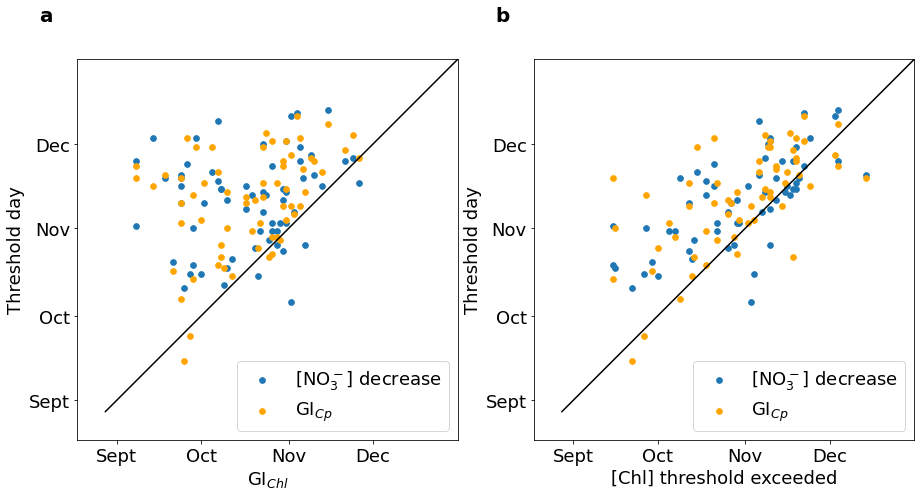

In [264]:
fig, (ax1,ax) = plt.subplots(1,2, figsize=(15,8))

mpl.rcParams.update({'font.size': 18, 'font.family': "sans-serif"})
DS_Timing.plot.scatter(ax=ax, x="Chl_thresh", y="NO3_thresh", s=32, label="[NO$_3^-$] decrease")
DS_Timing.plot.scatter(ax=ax, x="Chl_thresh", y="GI_C", color="orange", s=32, label="GI$_{Cp}$")
ax.set_xlim(230, 365)
ax.set_ylim(230, 365)
ax.legend(loc="lower right")
ax.set_xlabel("[Chl] threshold exceeded")
ax.set_ylabel("Threshold day")
ax.plot([240, 365], [240, 365], 'k-')
ax.set_xticks([244, 274, 305, 335])
ax.set_xticklabels(['Sept', 'Oct', 'Nov', "Dec"])
ax.set_yticks([244, 274, 305, 335])
ax.set_yticklabels(['Sept', 'Oct', 'Nov', "Dec"])

DS_Timing.plot.scatter(ax=ax1, x="GI", y="NO3_thresh", s=32, label="[NO$_3^-$] decrease")
DS_Timing.plot.scatter(ax=ax1, x="GI", y="GI_C", color="orange", s=32, label="GI$_{Cp}$")
ax1.set_xlim(230, 365)
ax1.set_ylim(230, 365)
ax1.legend(loc="lower right")
ax1.set_xlabel("GI$_{Chl}$")
ax1.set_ylabel("Threshold day")
ax1.plot([240, 365], [240, 365], 'k-')
ax1.set_xticks([244, 274, 305, 335])
ax1.set_xticklabels(['Sept', 'Oct', 'Nov', "Dec"])
ax1.set_yticks([244, 274, 305, 335])
ax1.set_yticklabels(['Sept', 'Oct', 'Nov', "Dec"])

#set aspect ratio to 1
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

#set aspect ratio to 1
ratio1 = 1.0
x_left1, x_right1 = ax1.get_xlim()
y_low1, y_high1 = ax1.get_ylim()
ax1.set_aspect(abs((x_right1-x_left1)/(y_low1-y_high1))*ratio1)

ax.text(-0.1, 1.1, "b", transform=ax.transAxes, 
            size=20, weight='bold')
ax1.text(-0.1, 1.1, "a", transform=ax1.transAxes, 
            size=20, weight='bold')

#fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Sup2Chl_GI_vsCpandN_threshold_comparison.pdf", dpi=400, bbox_inches='tight')


## Supplemental 3

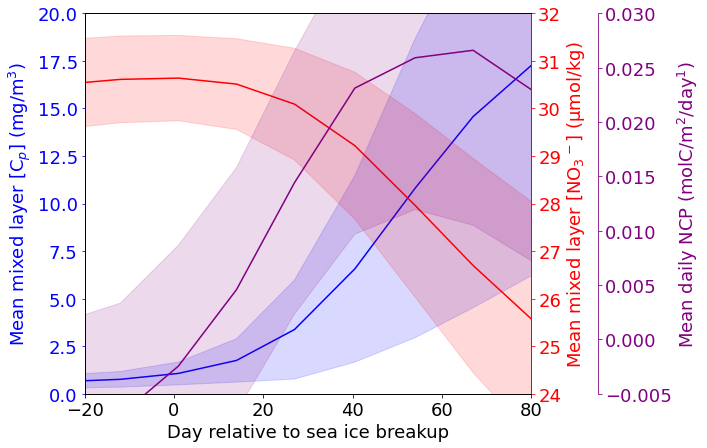

In [53]:
All_flts_bySIB=pd.DataFrame()
for i in range(len(All_flts_files)):
    ds=xr.open_dataset(All_flts_files[i])
    ds["fltyear"]=str(ds.Float_ID.values)+str(ds.JULD[0].dt.year.values)
    ds["NCP_daily"]=ds.NCP_daily
    ds["NCP_cumsum"]=ds.NCP_daily.cumsum()
    ds["fraction_NCP"]=ds.NCP_daily.cumsum()/ds.NCP
    ds["SIB_onset"]=np.mean([ds.O2_thresh.dt.dayofyear.values, ds.Salinity_thresh.dt.dayofyear.values, ds.SIC_thresh.dt.dayofyear.values])
    
    ds["SIB_onset"]=np.round(ds.SIB_onset.values)
    
    ds["days"]=ds.JULD.dt.floor("D").dt.dayofyear
    
    days=ds.JULD.dt.floor("D")
    
    SIB_date=ds.days.where(ds.days==ds.SIB_onset,drop=True)[0].JULD.dt.floor("D")
    
    SIB_days=np.zeros(len(days))
    for d in range(len(days)):
        SIB_days[d]=(days[d]-SIB_date).dt.days.values
    
    SIB_days=xr.DataArray(data=SIB_days, dims=ds.JULD.dims, coords=ds.JULD.coords)
    ds=ds.assign_coords({"SIB_days":SIB_days})
    ds=ds.swap_dims({"JULD":"SIB_days"})
    
    if np.all(np.diff(ds.SIB_days.values)) == False:
        print(SIB_days.values)
    
    output_ds=xr.Dataset(coords={"fltyear":ds.fltyear, "SIB_days":ds.SIB_days})
    
    output_ds["NCP_daily"]=ds.NCP_daily
    output_ds["SIC"]=ds.SIC
    output_ds["ML_Cp"]=ds.ML_Cp
    output_ds["ML_N"]=ds.ML_N
    output_ds["ML_S"]=ds.ML_S
    output_ds["ML_O"]=ds.ML_O
    #output_ds["NCP_positive_duration"]=ds.NCP_positive_duration
    
    output_ds=output_ds.expand_dims("fltyear")
    output_df=output_ds.to_dataframe()
    
    All_flts_bySIB=All_flts_bySIB.append(output_df)
    
#define bins
All_flts_bySIB_days=All_flts_bySIB.reset_index(["SIB_days"])
groups = pd.cut(All_flts_bySIB_days["SIB_days"], 30, right=True, include_lowest=True)

#display bin count by group variable
grouped_mean_SIB=All_flts_bySIB_days.groupby(groups).mean()
grouped_std_SIB=All_flts_bySIB_days.groupby(groups).std()

mpl.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8, 7))
x=grouped_mean_SIB.SIB_days

yC=grouped_mean_SIB.ML_Cp+grouped_std_SIB.ML_Cp
yC2=grouped_mean_SIB.ML_Cp-grouped_std_SIB.ML_Cp
#grouped_mean_SIB.ML_Cp.plot(ax=ax, label="Mixed layer Cp [mg/m3]", color="blue")
lineC=(grouped_mean_SIB.ML_Cp)#.plot(ax=ax, label="Daily NCP difference", color="navy")
ax.plot(x, lineC, color="blue")
ax.fill_between(x,yC, yC2, alpha=.15, color="blue")

ax1=ax.twinx()
yN=grouped_mean_SIB.ML_N+grouped_std_SIB.ML_N
yN2=grouped_mean_SIB.ML_N-grouped_std_SIB.ML_N
#grouped_mean_SIB.ML_N.plot(ax=ax1, label="Mixed layer nitrate [umol/kg]", color="red")
lineN=grouped_mean_SIB.ML_N
ax1.plot(x, lineN, color="red")
ax1.fill_between(x,yN, yN2, alpha=.15, color="red")

ax3=ax.twinx()
yNCP=grouped_mean_SIB.NCP_daily+grouped_std_SIB.NCP_daily
yNCP2=grouped_mean_SIB.NCP_daily-grouped_std_SIB.NCP_daily
#grouped_mean_SIB.NCP_daily.plot(ax=ax3, label="NCP [mol/m2/day]", color="purple")
lineNCP=grouped_mean_SIB.NCP_daily
ax3.plot(x, lineNCP, color="purple")
ax3.fill_between(x,yNCP, yNCP2, alpha=.15, color="purple")

ax3.set_ylim(-.005, .03)
#ax2.set_ylim(33.7,34.5)
ax1.set_ylim(24, 32)
ax.set_ylim(0, 20)
ax.set_ylabel("Mean mixed layer [C$_p$] (mg/m$^3$)")
ax1.set_ylabel("Mean mixed layer [NO$_3$$^-$] (µmol/kg)")
ax3.set_ylabel("Mean daily NCP (molC/m$^2$/day$^1$)")

ax1.spines["right"].set_position(("axes", 1))
ax3.spines["right"].set_position(("axes", 1.15))

ax.spines["right"].set_color("blue")
ax.yaxis.label.set_color('blue')
ax1.spines["right"].set_color("red")
ax1.yaxis.label.set_color('red')
ax3.spines["right"].set_color("purple")
ax3.yaxis.label.set_color('purple')
ax.tick_params(axis="y", colors="blue")
ax1.tick_params(axis="y", colors="red")
ax3.tick_params(axis="y", colors="purple")

ax.set_xlabel("Day relative to sea ice breakup")

ax.set_xlim(-20, 80)
fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Supp3NCPvsMLC_Ntiming.pdf", bbox_inches='tight', dpi=300)

    
   


In [243]:
rSIC, p_valueSIC = stats.pearsonr(DS_Timing.SIC15_duration.values, DS_Timing.NCP.values)
print(rSIC**2, "rsqrd ")
print(p_valueSIC, "p-value NCP and SIC<15% duration")

rGP, p_valuesGP = stats.pearsonr(DS_Timing.GP.values, DS_Timing.NCP.values)
print(rGP**2)
print(p_valuesGP, "p-value Ndrawdwon duration")

rml40, p_valueml40 = stats.pearsonr(DS_Timing.ML_40.values, DS_Timing.NCP.values)
print(rml40**2)
print(p_valueml40, "p-value ML<40m duration")

rlght, p_valueslght = stats.pearsonr(DS_Timing.median_light_sum.values, DS_Timing.NCP.values)
print(rlght**2)
print(p_valueslght, "p-value light")

0.11856007083351441 rsqrd 
0.00533532121681641 p-value NCP and SIC<15% duration
0.10533934544617049
0.008882226317538685 p-value Ndrawdwon duration
0.0008606874777398672
0.8179957580401614 p-value ML<40m duration
0.04547669111657374
0.0906612654734994 p-value light


In [30]:

rSIB, p_valueSIB = stats.pearsonr(DS_testing.SIB_onset.values, DS_testing.NCP.values)
print(rSIB**2, "rsqrd ")
print(p_valueSIB, "p-value NCP and SIB onset")


0.27451419266571025 rsqrd 
8.867206771026584e-06 p-value NCP and SIB onset


In [41]:
DS_Timing["GP"]=DS_Timing.GP.dt.days*-1

## Supplemental Fig 4

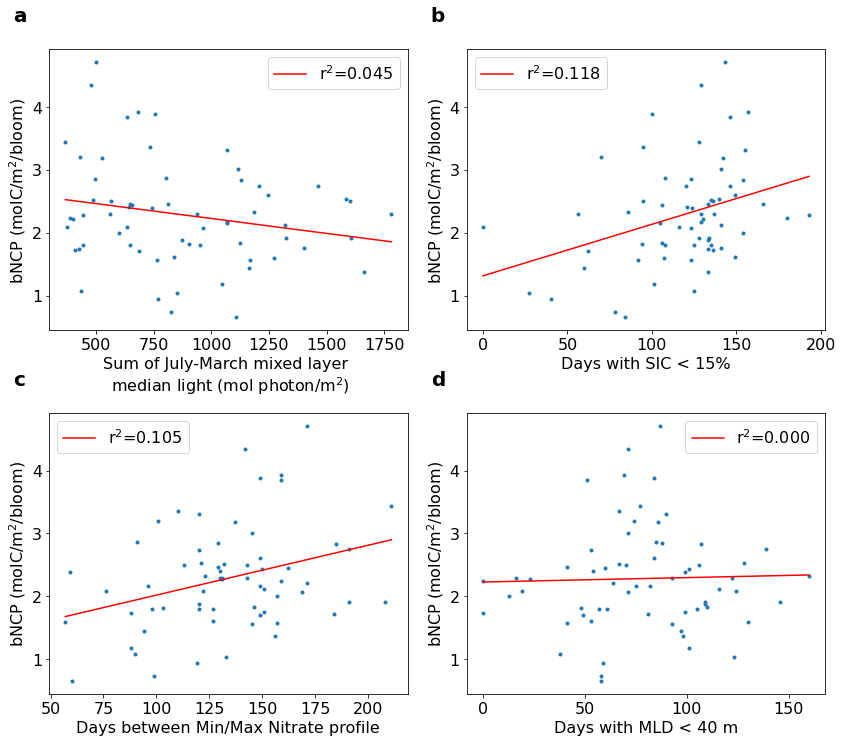

In [42]:
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2, figsize=(12,10), )

#ax1- Sum of mixed layer median light July-March
x1 = np.linspace(DS_Timing.median_light_sum.values.min(), DS_Timing.median_light_sum.values.max(), 500)
DS_Timing.plot.scatter(ax=ax1, x="median_light_sum", y="NCP", s=9)
z1 = np.polyfit(DS_Timing.median_light_sum.values, DS_Timing.NCP.values, 1)
p1 = np.poly1d(z1)
R2_1 = r2_score(DS_Timing.NCP.values, p1(DS_Timing.median_light_sum.values.reshape(-1, 1)))
#ax1.plot(np.sort(DS_Timing.median_light_sum.values), p1(DS_Timing.median_light_sum.values.reshape(-1, 1)),"r", label="R$^2$="+str(R2_1)[0:5])
ax1.plot(x1, p1(x1.reshape(-1,1)), "r", label="r$^2$="+str(R2_1)[0:5])
ax1.legend()
ax1.set_ylabel("bNCP (molC/m$^2$/bloom)")
ax1.set_xlabel("Sum of July-March mixed layer \n median light (mol photon/m$^2$)")

#ax2- Days SIC<15%
xx = np.linspace(DS_Timing.SIC15_duration.values.min(), DS_Timing.SIC15_duration.values.max(), 500)
DS_Timing.plot.scatter(ax=ax2, x="SIC15_duration", y="NCP", s=9)
z2 = np.polyfit(DS_Timing.SIC15_duration.values, DS_Timing.NCP.values, 1)
p2 = np.poly1d(z2)
R2_2 = r2_score(DS_Timing.NCP.values, p2(DS_Timing.SIC15_duration.values.reshape(-1, 1)))
#ax2.plot(DS_Timing.SIC15_duration.values, p2(DS_Timing.SIC15_duration.values.reshape(-1, 1)),"g", alpha=.02, label="R$^2$="+str(R2_2)[0:5])
ax2.plot(xx, p2(xx.reshape(-1, 1)),"r", label="r$^2$="+str(R2_2)[0:5])
ax2.legend()
ax2.set_ylabel("bNCP (molC/m$^2$/bloom)")
ax2.set_xlabel("Days with SIC < 15%")


#ax3 Duration N drawdown
x3=np.linspace(DS_Timing.GP.values.min(), DS_Timing.GP.values.max(), 500)
DS_Timing.plot.scatter(ax=ax3, x="GP", y="NCP",s=9)
z3 = np.polyfit(DS_Timing.GP.values, DS_Timing.NCP.values, 1)
p3 = np.poly1d(z3)
R2_3 = r2_score(DS_Timing.NCP.values, p3(DS_Timing.GP.values.reshape(-1, 1)))
#ax3.plot(DS_Timing.GP.values, p3(DS_Timing.GP.values.reshape(-1, 1)),"r", label="R$^2$="+str(R2_3)[0:5])
ax3.plot(x3, p3(x3.reshape(-1, 1)),"r", label="r$^2$="+str(R2_3)[0:5])
ax3.legend()
ax3.set_ylabel("bNCP (molC/m$^2$/bloom)")
ax3.set_xlabel("Days between Min/Max Nitrate profile")


#ax4 - Days MLD<40m
x4=np.linspace(DS_Timing.ML_40.values.min(), DS_Timing.ML_40.values.max(), 500)
DS_Timing.plot.scatter(ax=ax4, x="ML_40", y="NCP", s=9)
z4 = np.polyfit(DS_Timing.ML_40.values, DS_Timing.NCP.values, 1)
p4 = np.poly1d(z4)
R2_4 = r2_score(DS_Timing.NCP.values, p4(DS_Timing.ML_40.values.reshape(-1, 1)))
#ax4.plot(DS_Timing.ML_40.values, p4(DS_Timing.ML_40.values.reshape(-1, 1)),"r", label="R$^2$="+str(R2_4)[0:5])
ax4.plot(x4, p4(x4.reshape(-1, 1)),"r", label="r$^2$="+str(R2_4)[0:5])
ax4.legend()
ax4.set_ylabel("bNCP (molC/m$^2$/bloom)")
ax4.set_xlabel("Days with MLD < 40 m")
fig.tight_layout()

ax1.text(-0.1, 1.1, "a", transform=ax1.transAxes, 
            size=20, weight='bold')
ax2.text(-0.1, 1.1, "b", transform=ax2.transAxes, 
            size=20, weight='bold')
ax3.text(-0.1, 1.1, "c", transform=ax3.transAxes, 
            size=20, weight='bold')
ax4.text(-0.1, 1.1, "d", transform=ax4.transAxes, 
            size=20, weight='bold')


fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Supplement4_regressions.pdf", bbox_inches="tight", dpi=300)

## Suplemental Figure 5

In [45]:
fig, (ax, ax1, ax2)= plt.subplots(3,1 ,figsize=(8, 20), dpi= 80)

mpl.rcParams.update({'font.size': 16})
x1 = All_sliced_alldays.loc[All_sliced_alldays.SIB_group=='Early SIB', 'ML_Chl']
x2 = All_sliced_alldays.loc[All_sliced_alldays.SIB_group=='Late SIB', 'ML_Chl']
kwargs = dict(alpha=0.5, bins=40, density=True, stacked=True)

ax.hist(x1, **kwargs,color='dodgerblue', label='Early SIB', linewidth=1, edgecolor="white")
ax.hist(x2, **kwargs, color='orange', label='Late SIB', linewidth=1, edgecolor="white")

ax.set_title('Probability histogram of mixed layer [Chl]\n +/-50 days relative to total sea ice retreat')
ax.set_ylabel('Probability')
ax.set_xlabel("Mixed layer [Chl] (mg/m$^3$)")
ax.legend()

x1cp = All_sliced_alldays.loc[All_sliced_alldays.SIB_group=='Early SIB', 'ML_Cp']
x2cp = All_sliced_alldays.loc[All_sliced_alldays.SIB_group=='Late SIB', 'ML_Cp']

ax1.hist(x1cp, **kwargs,color='dodgerblue', label='Early SIB', linewidth=1, edgecolor="white")
ax1.hist(x2cp, **kwargs, color='orange', label='Late SIB', linewidth=1, edgecolor="white")

ax1.set_title('Probability histogram of mixed layer [C$_p$]\n +/-50 days relative to total sea ice retreat ')
ax1.set_ylabel('Probability')
ax1.set_xlabel("Mixed layer [C$_p$] (mg/m$^3$)")
ax1.legend()

x1NCP = All_slicedb4_alldays.loc[All_slicedb4_alldays.SIB_group=='Early SIB', 'NCP_daily']
x2NCP = All_slicedb4_alldays.loc[All_slicedb4_alldays.SIB_group=='Late SIB', 'NCP_daily']

ax2.hist(x1NCP, **kwargs,color='dodgerblue', label='Early SIB', linewidth=1, edgecolor="white")
ax2.hist(x2NCP, **kwargs, color='orange', label='Late SIB', linewidth=1, edgecolor="white")

ax2.set_title('Probability histogram of daily NCP \n 50 days prior to total sea ice retreat ')
ax2.set_ylabel('Probability')
ax2.set_xlabel("Daily NCP (molC/m$^2$/day)")
ax2.legend()

ax.text(-0.1, 1.1, "a", transform=ax.transAxes, 
            size=20, weight='bold')
ax2.text(-0.1, 1.1, "c", transform=ax2.transAxes, 
            size=20, weight='bold')
ax1.text(-0.1, 1.1, "b", transform=ax1.transAxes, 
            size=20, weight='bold')


fig.tight_layout()
fig.savefig("/Users/Shannonmcclish/Dropbox/Projects/2021_09UnderIceBGCMcClish/Paper_figures/vf/Supplement5_histograms.pdf", bbox_inches="tight", dpi=300)


All_flts_bNCP_period=pd.DataFrame()


for i in range(len(All_flts_files)):
    ds=xr.open_dataset(All_flts_files[i])
    ds["fltyear"]=str(ds.Float_ID.values)+str(ds.JULD[0].dt.year.values)
    ds=ds.sel(JULD=slice(ds.Nint_max_date[0].values, ds.Nint_min_date[0].values))
    ds["NCP_daily"]=ds.NCP_daily
    ds["NCP_cumsum"]=ds.NCP_daily.cumsum()
    ds["fraction_NCP"]=ds.NCP_daily.cumsum()/ds.NCP
    days=ds.JULD.dt.floor("D")
    SIC_last=ds.SIC.where(ds.SIC==ds.SIC.min(),drop=True)[0].JULD.dt.floor("D")
    SIC_days=np.zeros(len(days))
    for d in range(len(days)):
        SIC_days[d]=(days[d]-SIC_last).dt.days.values
    SIC_days=xr.DataArray(data=SIC_days, dims=ds.JULD.dims, coords=ds.JULD.coords)
    ds=ds.assign_coords({"SIC_days":SIC_days})
    ds=ds.swap_dims({"JULD":"SIC_days"})
    if np.all(np.diff(ds.SIC_days.values)) == False:
        print(SIC_days.values)
    output_ds=xr.Dataset(coords={"fltyear":ds.fltyear, "SIC_days":ds.SIC_days})
    output_ds["Float_ID"]=ds.Float_ID.values
    output_ds["FracNCP"]=ds.fraction_NCP
    output_ds=output_ds.expand_dims("fltyear")
    output_df=output_ds.to_dataframe()
    
    All_flts_bNCP_period=All_flts_bNCP_period.append(output_df)
    


In [46]:
ds_all_flts=xr.Dataset()

ds_all_flts["FracNCP_mean"]=All_flts_DF["FracNCP"].groupby("SIC_days").mean()
ds_all_flts["FracNCP_std"]=All_flts_DF["FracNCP"].groupby("SIC_days").std()
